In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Step 2: Load and examine the dataset
try:
    data = pd.read_csv('Dataset_2.csv')
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {data.shape}")
    print("\nFirst 5 rows:")
    print(data.head())
except FileNotFoundError:
    print("Dataset_2.csv not found. Please check the file path.")
except Exception as e:
    print(f"Error loading dataset: {e}")


Dataset loaded successfully!
Dataset shape: (8950, 18)

First 5 rows:
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000    

In [3]:
'''def engineer_features(df):
    """Create interaction features and derived metrics for clustering"""
    print("\n=== FEATURE ENGINEERING ===")
    
    # Make a copy to avoid modifying the original
    df_engineered = df.copy()
    
    # 1. Income-based features
    if 'Income' in df.columns:
        # Spending capacity: Income relative to family size
        if 'Family_Size' in df.columns:
            df_engineered['Income_Per_Family_Member'] = df['Income'] / df['Family_Size'].clip(lower=1)
            print("✓ Created: Income_Per_Family_Member")
    
    # 2. Age-based features
    if 'Age' in df.columns:
        # Life stage buckets
        df_engineered['Life_Stage'] = pd.cut(
            df['Age'], 
            bins=[0, 25, 35, 50, 65, 100],
            labels=['Young_Adult', 'Early_Career', 'Mid_Career', 'Late_Career', 'Retired']
        )
        print("✓ Created: Life_Stage categorical feature")
        
        # Age-Income interaction
        if 'Income' in df.columns:
            df_engineered['Income_Age_Ratio'] = df['Income'] / df['Age']
            print("✓ Created: Income_Age_Ratio")
    
    # 3. Purchase behavior features
    if all(col in df.columns for col in ['Balance', 'Purchases']):
        # Purchasing power utilization
        df_engineered['Purchase_To_Balance_Ratio'] = df['Purchases'] / df['Balance'].clip(lower=1)
        print("✓ Created: Purchase_To_Balance_Ratio")
    
    # 4. Credit-related features
    if all(col in df.columns for col in ['Credit_Limit', 'Balance']):
        # Credit utilization rate
        df_engineered['Credit_Utilization'] = df['Balance'] / df['Credit_Limit'].clip(lower=1)
        print("✓ Created: Credit_Utilization")
    
    # 5. Spending pattern features
    if all(col in df.columns for col in ['OneOff_Purchases', 'Installments_Purchases']):
        # Total purchases
        df_engineered['Total_Purchases'] = df['OneOff_Purchases'] + df['Installments_Purchases']
        
        # Purchase preference (one-off vs installments)
        df_engineered['OneOff_Purchase_Ratio'] = df['OneOff_Purchases'] / df_engineered['Total_Purchases'].clip(lower=1)
        print("✓ Created: Total_Purchases and OneOff_Purchase_Ratio")
    
    # 6. RFM (Recency, Frequency, Monetary) analysis features
    if all(col in df.columns for col in ['Purchases_Frequency', 'Purchases']):
        # Average purchase value
        df_engineered['Avg_Purchase_Value'] = df['Purchases'] / df['Purchases_Frequency'].clip(lower=0.01)
        print("✓ Created: Avg_Purchase_Value")
    
    # 7. Customer engagement score (composite metric)
    engagement_cols = ['Purchases_Frequency', 'Purchases_Installments_Frequency', 'Cash_Advance_Frequency']
    if all(col in df.columns for col in engagement_cols):
        # Combined engagement score
        df_engineered['Engagement_Score'] = df[engagement_cols].mean(axis=1)
        print("✓ Created: Engagement_Score")
    
    print(f"Feature engineering complete. Added {len(df_engineered.columns) - len(df.columns)} new features.")
    print(f"New dataset shape: {df_engineered.shape}")
    
    return df_engineered

# Use this function before preprocessing:
data_with_features = engineer_features(data)
# Then continue with your preprocessing on data_with_features'''

'def engineer_features(df):\n    """Create interaction features and derived metrics for clustering"""\n    print("\n=== FEATURE ENGINEERING ===")\n    \n    # Make a copy to avoid modifying the original\n    df_engineered = df.copy()\n    \n    # 1. Income-based features\n    if \'Income\' in df.columns:\n        # Spending capacity: Income relative to family size\n        if \'Family_Size\' in df.columns:\n            df_engineered[\'Income_Per_Family_Member\'] = df[\'Income\'] / df[\'Family_Size\'].clip(lower=1)\n            print("✓ Created: Income_Per_Family_Member")\n    \n    # 2. Age-based features\n    if \'Age\' in df.columns:\n        # Life stage buckets\n        df_engineered[\'Life_Stage\'] = pd.cut(\n            df[\'Age\'], \n            bins=[0, 25, 35, 50, 65, 100],\n            labels=[\'Young_Adult\', \'Early_Career\', \'Mid_Career\', \'Late_Career\', \'Retired\']\n        )\n        print("✓ Created: Life_Stage categorical feature")\n        \n        # Age-Income i

In [4]:
'''# Step 4: Data Preprocessing
def preprocess_data(df):
    print("=== DATA PREPROCESSING ===")
    
    # Make a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Handle missing values
    print(f"Missing values before handling: {df_processed.isnull().sum().sum()}")
    
    # For numerical columns: fill with median
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    # For categorical columns: fill with mode
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    print(f"Missing values after handling: {df_processed.isnull().sum().sum()}")
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded column: {col}")
    
    # Remove any ID columns (typically first column)
    if 'ID' in df_processed.columns or 'id' in df_processed.columns:
        df_processed = df_processed.drop(['ID', 'id'], axis=1, errors='ignore')
    
    print(f"Final processed dataset shape: {df_processed.shape}")
    return df_processed, label_encoders

# Preprocess the data
data_processed, encoders = preprocess_data(data)'''

'# Step 4: Data Preprocessing\ndef preprocess_data(df):\n    print("=== DATA PREPROCESSING ===")\n    \n    # Make a copy to avoid modifying original data\n    df_processed = df.copy()\n    \n    # Handle missing values\n    print(f"Missing values before handling: {df_processed.isnull().sum().sum()}")\n    \n    # For numerical columns: fill with median\n    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns\n    for col in numerical_cols:\n        if df_processed[col].isnull().sum() > 0:\n            df_processed[col].fillna(df_processed[col].median(), inplace=True)\n    \n    # For categorical columns: fill with mode\n    categorical_cols = df_processed.select_dtypes(include=[\'object\']).columns\n    for col in categorical_cols:\n        if df_processed[col].isnull().sum() > 0:\n            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)\n    \n    print(f"Missing values after handling: {df_processed.isnull().sum().sum()}")\n    \n    # Enco

In [5]:
# Enhanced Step 4: Data Preprocessing with Categorical Handling
def preprocess_data(df):
    print("=== DATA PREPROCESSING ===")
    
    # Make a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Handle missing values
    print(f"Missing values before handling: {df_processed.isnull().sum().sum()}")
    
    # For numerical columns: fill with median
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    # For categorical columns: fill with mode
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    print(f"Categorical columns found: {categorical_cols.tolist()}")
    
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    print(f"Missing values after handling: {df_processed.isnull().sum().sum()}")
    
    # Store original categorical data for later analysis
    categorical_backup = {}
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        if col not in ['CUST_ID', 'ID', 'id']:  # Skip ID columns
            # Store original values
            categorical_backup[col] = df_processed[col].copy()
            
            # Encode categorical variable
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
            label_encoders[col] = le
            print(f"Encoded column: {col} - {len(le.classes_)} unique categories")
    
    # Remove ID columns
    id_columns = [col for col in df_processed.columns if col.upper() in ['CUST_ID', 'ID', 'CUSTOMER_ID']]
    if id_columns:
        print(f"Removing ID columns: {id_columns}")
        df_processed = df_processed.drop(id_columns, axis=1)
    
    print(f"Final processed dataset shape: {df_processed.shape}")
    print(f"Final columns: {df_processed.columns.tolist()}")
    
    return df_processed, label_encoders, categorical_backup

# Preprocess the data
data_processed, encoders, categorical_backup = preprocess_data(data)

=== DATA PREPROCESSING ===
Missing values before handling: 314
Categorical columns found: ['CUST_ID']
Missing values after handling: 0
Removing ID columns: ['CUST_ID']
Final processed dataset shape: (8950, 17)
Final columns: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [6]:
# Step 4b: Outlier Detection and Treatment
def detect_and_treat_outliers(df, method='iqr', threshold=1.5, contamination=0.05):
    """
    Detect and handle outliers using various methods
    
    Parameters:
    - df: DataFrame with preprocessed data
    - method: 'iqr' for Interquartile Range or 'isolation_forest' for Isolation Forest
    - threshold: IQR multiplier for outlier detection (for IQR method)
    - contamination: Expected proportion of outliers (for Isolation Forest)
    
    Returns:
    - df_cleaned: DataFrame with outliers treated
    - outlier_indices: Dictionary mapping column names to lists of outlier indices
    - outlier_stats: DataFrame with statistics about detected outliers
    """
    print("=== OUTLIER DETECTION AND TREATMENT ===")
    
    df_cleaned = df.copy()
    outlier_indices = {}
    outlier_stats = pd.DataFrame(columns=['Column', 'Outliers_Count', 'Outliers_Percentage', 'Method'])
    
    # Only process numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Checking {len(numerical_cols)} numerical columns for outliers")
    
    if method == 'iqr':
        for col in numerical_cols:
            # Calculate IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define outlier boundaries
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            # Identify outliers
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound))
            outlier_indices[col] = df[outliers].index.tolist()
            
            # Cap outliers
            df_cleaned.loc[df[col] < lower_bound, col] = lower_bound
            df_cleaned.loc[df[col] > upper_bound, col] = upper_bound
            
            # Collect statistics
            outlier_count = sum(outliers)
            outlier_stats = outlier_stats.append({
                'Column': col,
                'Outliers_Count': outlier_count,
                'Outliers_Percentage': outlier_count / len(df) * 100,
                'Method': 'IQR'
            }, ignore_index=True)
            
            print(f"Column {col}: {outlier_count} outliers detected and capped ({outlier_count/len(df)*100:.2f}%)")
            
    elif method == 'isolation_forest':
        from sklearn.ensemble import IsolationForest
        
        # Apply Isolation Forest to all numerical columns at once
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        outliers = iso_forest.fit_predict(df[numerical_cols]) == -1
        
        # Record statistics
        outlier_count = sum(outliers)
        print(f"Isolation Forest detected {outlier_count} outliers ({outlier_count/len(df)*100:.2f}%)")
        
        # Create a temporary column to mark outliers
        df_cleaned['is_outlier'] = outliers
        
        # For each outlier, replace with median or winsorize
        for col in numerical_cols:
            # Get median value for the column
            median_val = df[col].median()
            
            # Replace outlier values with column median
            df_cleaned.loc[df_cleaned['is_outlier'], col] = median_val
        
        # Remove temporary column
        df_cleaned.drop('is_outlier', axis=1, inplace=True)
        
        outlier_stats = outlier_stats.append({
            'Column': 'All numerical columns',
            'Outliers_Count': outlier_count,
            'Outliers_Percentage': outlier_count / len(df) * 100,
            'Method': 'Isolation Forest'
        }, ignore_index=True)
    
    # Ensure Outliers_Count is numeric for nlargest
    outlier_stats['Outliers_Count'] = pd.to_numeric(outlier_stats['Outliers_Count'], errors='coerce')
    
    # Visualize outlier distribution in top features
    top_outlier_cols = outlier_stats.nlargest(min(6, len(outlier_stats)), 'Outliers_Count')['Column'].tolist()
    if method == 'isolation_forest':
        top_outlier_cols = numerical_cols[:6]  # Just use first 6 columns
    
    # Create boxplots to visualize outliers
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(top_outlier_cols[:6]):  # Show at most 6 boxplots
        if i < len(axes):
            # Original data with outliers
            sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
            axes[i].set_title(f'Distribution of {col} (before treatment)')
            
            # Add treated data
            sns.boxplot(x=df_cleaned[col], ax=axes[i], color='lightgreen')
            axes[i].legend(['Original', 'Treated'])
    
    # Hide unused subplots
    for i in range(len(top_outlier_cols), 6):
        if i < len(axes):
            axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nOutlier treatment complete. Total columns processed: {len(numerical_cols)}")
    print(f"Summary of outliers found and treated:")
    print(outlier_stats)
    
    return df_cleaned, outlier_indices, outlier_stats

# Utility function to scale features using StandardScaler
from sklearn.preprocessing import StandardScaler

def scale_features(df, exclude_columns=['CUST_ID', 'Customer_Tenure_Stage']):
    """
    Scales numerical features in the DataFrame using StandardScaler.
    Excludes specified columns from scaling.
    
    Returns:
    - scaled_df: DataFrame with scaled features
    - scaler: fitted StandardScaler object
    """
    # Identify columns to scale
    cols_to_scale = df.select_dtypes(include=[np.number]).columns.difference(exclude_columns)
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df[cols_to_scale])
    scaled_df = df.copy()
    scaled_df[cols_to_scale] = scaled_values
    return scaled_df, scaler

# Apply outlier detection and treatment between preprocessing and scaling
data_outlier_treated, outlier_indices, outlier_stats = detect_and_treat_outliers(
    data_with_features, 
    method='iqr',  # Try 'iqr' first, then experiment with 'isolation_forest'
    threshold=2.0  # More conservative than default 1.5 to avoid over-capping
)

# Update your code to use the outlier-treated data for scaling
data_scaled, scaler = scale_features(data_outlier_treated)

NameError: name 'data_with_features' is not defined

In [7]:
def engineer_features_adapted(df):
    """Create interaction features and derived metrics for clustering"""
    print("\n=== FEATURE ENGINEERING ===")
    
    # Make a copy to avoid modifying the original
    df_engineered = df.copy()
    
    # Get actual column names for reference
    print("Available columns:", df.columns.tolist())
    
    # 1. Credit-related features - using CREDIT_LIMIT instead of Income
    if 'CREDIT_LIMIT' in df.columns:
        # Credit utilization rate
        if 'BALANCE' in df.columns:
            df_engineered['Credit_Utilization'] = df['BALANCE'] / df['CREDIT_LIMIT'].clip(lower=1)
            print("✓ Created: Credit_Utilization")
    
    # 2. Age-based features - using TENURE as a proxy for age
    if 'TENURE' in df.columns:
        # Life stage buckets based on tenure (adjust bins as needed)
        df_engineered['Customer_Tenure_Stage'] = pd.cut(
            df['TENURE'], 
            bins=[0, 3, 7, 11, 15, 100],
            labels=['New', 'Developing', 'Established', 'Mature', 'Loyal']
        )
        print("✓ Created: Customer_Tenure_Stage categorical feature")
        
        # Tenure-Credit interaction
        if 'CREDIT_LIMIT' in df.columns:
            df_engineered['Credit_Tenure_Ratio'] = df['CREDIT_LIMIT'] / df['TENURE'].clip(lower=1)
            print("✓ Created: Credit_Tenure_Ratio")
    
    # 3. Purchase behavior features
    if all(col in df.columns for col in ['BALANCE', 'PURCHASES']):
        # Purchasing power utilization
        df_engineered['Purchase_To_Balance_Ratio'] = df['PURCHASES'] / df['BALANCE'].clip(lower=1)
        print("✓ Created: Purchase_To_Balance_Ratio")
    
    # 4. Spending pattern features
    if all(col in df.columns for col in ['ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES']):
        # Total purchases
        df_engineered['Total_Purchases'] = df['ONEOFF_PURCHASES'] + df['INSTALLMENTS_PURCHASES']
        
        # Purchase preference (one-off vs installments)
        df_engineered['OneOff_Purchase_Ratio'] = df['ONEOFF_PURCHASES'] / df_engineered['Total_Purchases'].clip(lower=1)
        print("✓ Created: Total_Purchases and OneOff_Purchase_Ratio")
    
    # 5. RFM (Recency, Frequency, Monetary) analysis features
    if all(col in df.columns for col in ['PURCHASES_FREQUENCY', 'PURCHASES']):
        # Average purchase value
        df_engineered['Avg_Purchase_Value'] = df['PURCHASES'] / df['PURCHASES_FREQUENCY'].clip(lower=0.01)
        print("✓ Created: Avg_Purchase_Value")
    
    # 6. Customer engagement score (composite metric)
    engagement_cols = ['PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']
    if all(col in df.columns for col in engagement_cols):
        # Combined engagement score
        df_engineered['Engagement_Score'] = df[engagement_cols].mean(axis=1)
        print("✓ Created: Engagement_Score")
    
    print(f"Feature engineering complete. Added {len(df_engineered.columns) - len(df.columns)} new features.")
    print(f"New dataset shape: {df_engineered.shape}")
    
    return df_engineered

# Replace your original call with:
data_with_features = engineer_features_adapted(data)
# Then continue with your preprocessing on data_with_features


=== FEATURE ENGINEERING ===
Available columns: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
✓ Created: Credit_Utilization
✓ Created: Customer_Tenure_Stage categorical feature
✓ Created: Credit_Tenure_Ratio
✓ Created: Purchase_To_Balance_Ratio
✓ Created: Total_Purchases and OneOff_Purchase_Ratio
✓ Created: Avg_Purchase_Value
✓ Created: Engagement_Score
Feature engineering complete. Added 8 new features.
New dataset shape: (8950, 26)


=== PCA Analysis - Before Clustering ===
Components needed for 85% variance: 4
Components needed for 95% variance: 5


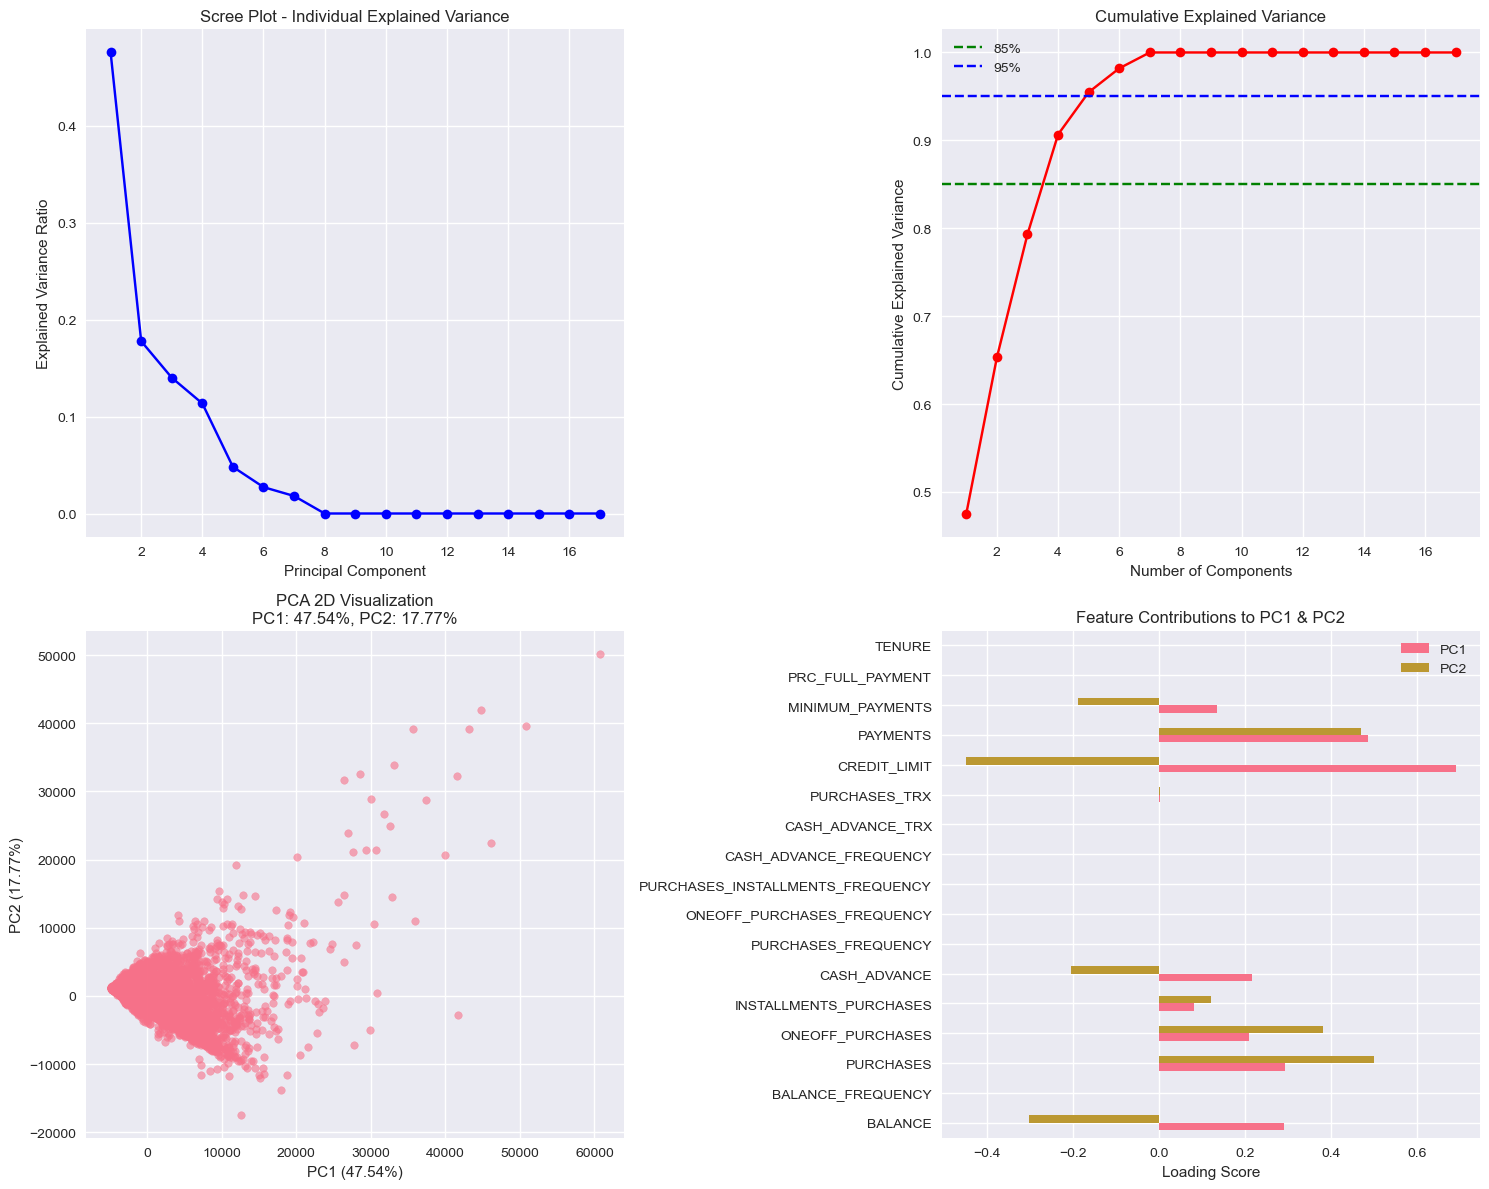

In [8]:
# New Step 5a: PCA Analysis Before Clustering
def perform_pca_analysis(data, title="PCA Analysis"):
    print(f"=== {title} ===")
    
    # Perform PCA with all components first to see explained variance
    pca_full = PCA()
    pca_full.fit(data)
    
    # Calculate cumulative explained variance ratio
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    
    # Find number of components for 85% and 95% variance
    n_components_85 = np.argmax(cumvar >= 0.85) + 1
    n_components_95 = np.argmax(cumvar >= 0.95) + 1
    
    print(f"Components needed for 85% variance: {n_components_85}")
    print(f"Components needed for 95% variance: {n_components_95}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Scree Plot
    axes[0,0].plot(range(1, min(21, len(pca_full.explained_variance_ratio_)+1)), 
                   pca_full.explained_variance_ratio_[:20], 'bo-')
    axes[0,0].set_title('Scree Plot - Individual Explained Variance')
    axes[0,0].set_xlabel('Principal Component')
    axes[0,0].set_ylabel('Explained Variance Ratio')
    axes[0,0].grid(True)
    
    # 2. Cumulative Explained Variance
    axes[0,1].plot(range(1, min(21, len(cumvar)+1)), cumvar[:20], 'ro-')
    axes[0,1].axhline(y=0.85, color='g', linestyle='--', label='85%')
    axes[0,1].axhline(y=0.95, color='b', linestyle='--', label='95%')
    axes[0,1].set_title('Cumulative Explained Variance')
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Cumulative Explained Variance')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # 3. PCA 2D visualization (first 2 components)
    pca_2d = PCA(n_components=2)
    data_pca_2d = pca_2d.fit_transform(data)
    
    axes[1,0].scatter(data_pca_2d[:, 0], data_pca_2d[:, 1], alpha=0.6, s=30)
    axes[1,0].set_title(f'PCA 2D Visualization\nPC1: {pca_2d.explained_variance_ratio_[0]:.2%}, PC2: {pca_2d.explained_variance_ratio_[1]:.2%}')
    axes[1,0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
    axes[1,0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
    
    # 4. Feature contributions to first 2 PCs
    feature_names = data.columns if hasattr(data, 'columns') else [f'Feature_{i}' for i in range(data.shape[1])]
    
    # Create a dataframe for better visualization
    pc_df = pd.DataFrame(
        pca_2d.components_.T,
        columns=['PC1', 'PC2'],
        index=feature_names
    )
    
    # Plot feature contributions
    pc_df.plot(kind='barh', ax=axes[1,1])
    axes[1,1].set_title('Feature Contributions to PC1 & PC2')
    axes[1,1].set_xlabel('Loading Score')
    
    plt.tight_layout()
    plt.show()
    
    return pca_2d, data_pca_2d, n_components_85, n_components_95

# Perform PCA analysis before clustering (using unscaled data as data_scaled is not yet defined)
pca_before, data_pca_2d_before, n_comp_85, n_comp_95 = perform_pca_analysis(data_processed, "PCA Analysis - Before Clustering")

In [10]:
# Step 5: Feature Scaling
def scale_features(df):
    print("=== FEATURE SCALING ===")
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    
    print("Features scaled using StandardScaler")
    print(f"Scaled data shape: {scaled_df.shape}")
    return scaled_df, scaler

# Scale the features
data_scaled, scaler = scale_features(data_processed)
print("Scaled data preview:")
print(data_scaled.head())

=== FEATURE SCALING ===
Features scaled using StandardScaler
Scaled data shape: (8950, 17)
Scaled data preview:
    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                         -0.

=== EXPLORATORY DATA ANALYSIS ===


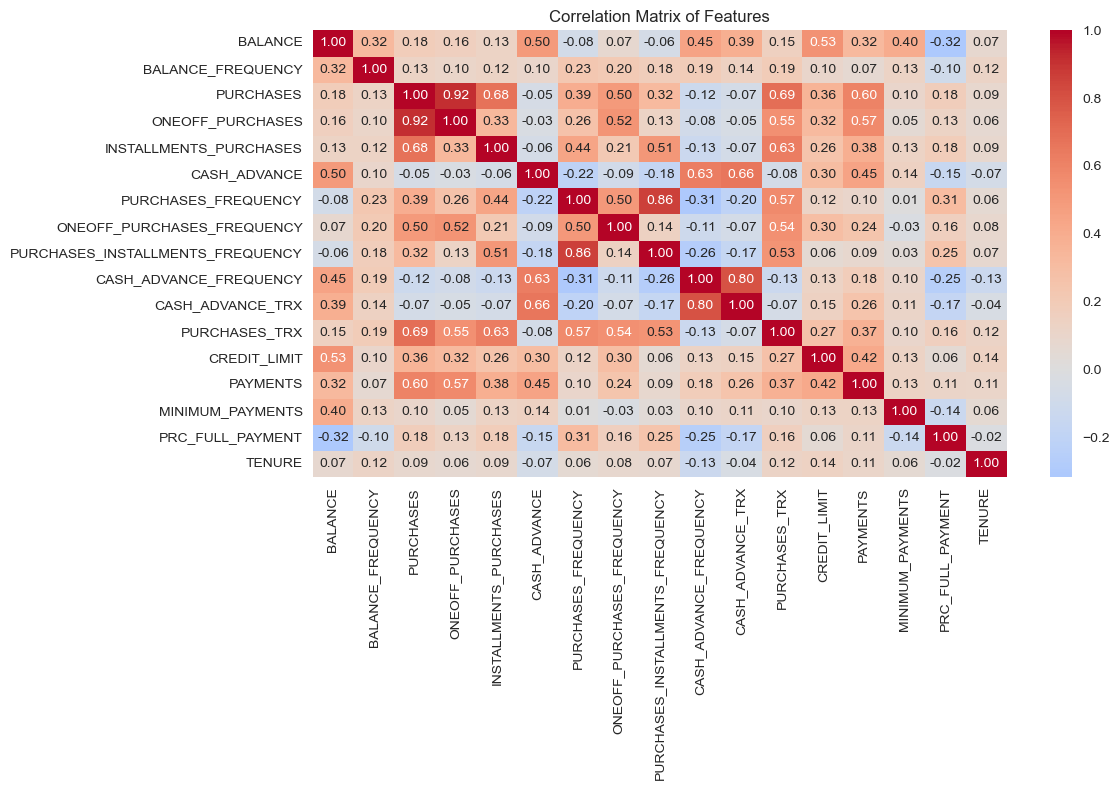

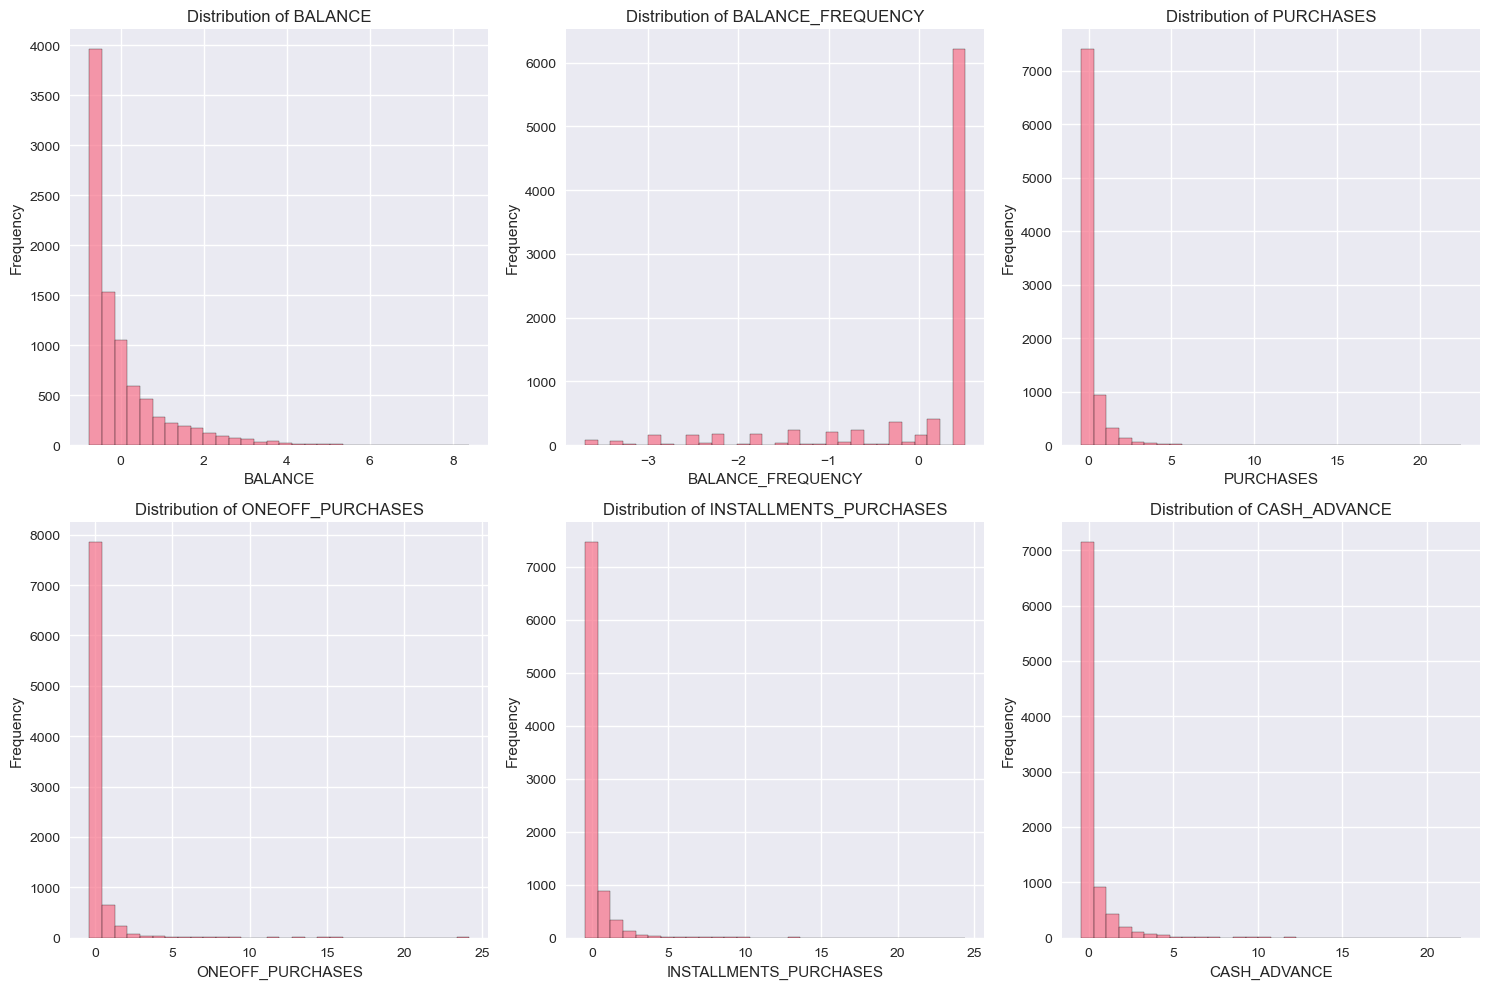

In [11]:
# Step 6: Exploratory Data Analysis
def perform_eda(df_original, df_scaled):
    print("=== EXPLORATORY DATA ANALYSIS ===")
    
    # Correlation matrix
    plt.figure(figsize=(12, 8))
    correlation_matrix = df_scaled.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Features')
    plt.tight_layout()
    plt.show()
    
    # Distribution plots for key numerical features
    numerical_features = df_scaled.columns[:6]  # First 6 numerical features
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(numerical_features, 1):
        plt.subplot(2, 3, i)
        plt.hist(df_scaled[feature], bins=30, alpha=0.7, edgecolor='black')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Perform EDA
perform_eda(data_processed, data_scaled)

=== FINDING OPTIMAL NUMBER OF CLUSTERS ===


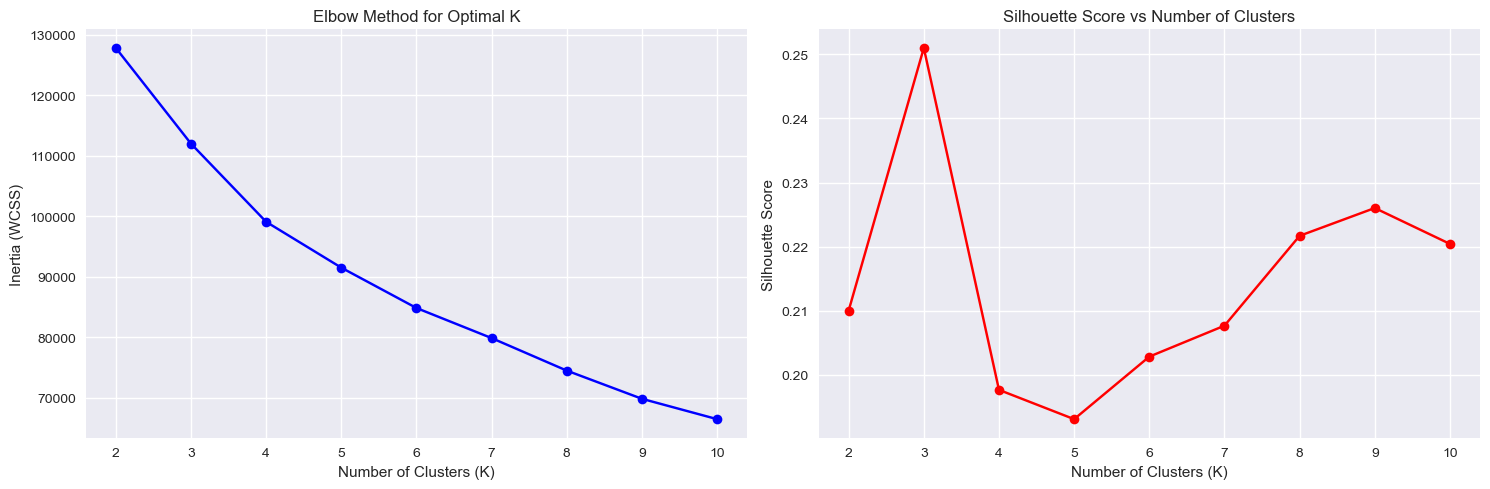

Optimal number of clusters based on silhouette score: 3


In [12]:
# Step 7: Determine Optimal Number of Clusters
def find_optimal_clusters(data, max_k=10):
    print("=== FINDING OPTIMAL NUMBER OF CLUSTERS ===")
    
    # Elbow Method for K-Means
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    # Plot Elbow Curve
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'bo-')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (WCSS)')
    plt.grid(True)
    
    # Plot Silhouette Scores
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k based on silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
    
    return optimal_k, silhouette_scores, inertias

# Remove 'CUST_ID' and categorical columns if present for clustering
# Use the cleaned version without NaNs

# Prepare data_scaled_for_clustering_clean
cols_to_drop = []
if 'CUST_ID' in data_scaled.columns:
    cols_to_drop.append('CUST_ID')
# Drop any object or category columns
cols_to_drop += [col for col in data_scaled.select_dtypes(include=['object', 'category']).columns if col not in cols_to_drop]
data_scaled_for_clustering_clean = data_scaled.drop(columns=cols_to_drop).dropna()

# Find optimal clusters
optimal_k, silhouette_scores, inertias = find_optimal_clusters(data_scaled_for_clustering_clean)

In [13]:
# Step 8: Apply Different Clustering Algorithms

def apply_kmeans_clustering(data, n_clusters):
    print(f"=== K-MEANS CLUSTERING (k={n_clusters}) ===")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    
    # Calculate metrics
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Calinski-Harabasz Score: {calinski:.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
    
    return kmeans, labels, {'silhouette': silhouette, 'calinski': calinski, 'davies_bouldin': davies_bouldin}

def apply_hierarchical_clustering(data, n_clusters):
    print(f"=== HIERARCHICAL CLUSTERING (k={n_clusters}) ===")
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = hierarchical.fit_predict(data)
    
    # Calculate metrics
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Calinski-Harabasz Score: {calinski:.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
    
    return hierarchical, labels, {'silhouette': silhouette, 'calinski': calinski, 'davies_bouldin': davies_bouldin}

def apply_dbscan_clustering(data, eps=0.5, min_samples=5):
    print(f"=== DBSCAN CLUSTERING (eps={eps}, min_samples={min_samples}) ===")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    
    if n_clusters > 1:
        # Only calculate metrics if we have more than one cluster
        mask = labels != -1  # Remove noise points for metric calculation
        if mask.sum() > 0:
            silhouette = silhouette_score(data[mask], labels[mask])
            calinski = calinski_harabasz_score(data[mask], labels[mask])
            davies_bouldin = davies_bouldin_score(data[mask], labels[mask])
        else:
            silhouette = calinski = davies_bouldin = -1
    else:
        silhouette = calinski = davies_bouldin = -1
    
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Calinski-Harabasz Score: {calinski:.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
    
    return dbscan, labels, {'silhouette': silhouette, 'calinski': calinski, 'davies_bouldin': davies_bouldin}

def apply_gaussian_mixture_clustering(data, n_clusters):
    print(f"=== GAUSSIAN MIXTURE MODEL (k={n_clusters}) ===")
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    labels = gmm.fit_predict(data)
    
    # Calculate metrics
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Calinski-Harabasz Score: {calinski:.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"AIC: {gmm.aic(data):.4f}")
    print(f"BIC: {gmm.bic(data):.4f}")
    
    return gmm, labels, {'silhouette': silhouette, 'calinski': calinski, 'davies_bouldin': davies_bouldin}

# Apply all clustering methods
clustering_results = {}# K-Means
kmeans_model, kmeans_labels, kmeans_metrics = apply_kmeans_clustering(data_scaled_for_clustering_clean, optimal_k)
clustering_results['K-Means'] = {'model': kmeans_model, 'labels': kmeans_labels, 'metrics': kmeans_metrics}

# Hierarchical
hierarchical_model, hierarchical_labels, hierarchical_metrics = apply_hierarchical_clustering(data_scaled_for_clustering_clean, optimal_k)
clustering_results['Hierarchical'] = {'model': hierarchical_model, 'labels': hierarchical_labels, 'metrics': hierarchical_metrics}

# DBSCAN
dbscan_model, dbscan_labels, dbscan_metrics = apply_dbscan_clustering(data_scaled_for_clustering_clean, eps=0.5, min_samples=5)
clustering_results['DBSCAN'] = {'model': dbscan_model, 'labels': dbscan_labels, 'metrics': dbscan_metrics}

# Gaussian Mixture
gmm_model, gmm_labels, gmm_metrics = apply_gaussian_mixture_clustering(data_scaled_for_clustering_clean, optimal_k)
clustering_results['Gaussian Mixture'] = {'model': gmm_model, 'labels': gmm_labels, 'metrics': gmm_metrics}

=== K-MEANS CLUSTERING (k=3) ===
Silhouette Score: 0.2510
Calinski-Harabasz Score: 1605.0264
Davies-Bouldin Score: 1.5920
=== HIERARCHICAL CLUSTERING (k=3) ===
Silhouette Score: 0.1674
Calinski-Harabasz Score: 1239.3256
Davies-Bouldin Score: 1.8496
=== DBSCAN CLUSTERING (eps=0.5, min_samples=5) ===
Number of clusters: 36
Number of noise points: 6624
Silhouette Score: -0.3758
Calinski-Harabasz Score: 29.0876
Davies-Bouldin Score: 0.9663
=== GAUSSIAN MIXTURE MODEL (k=3) ===
Silhouette Score: 0.0978
Calinski-Harabasz Score: 815.7820
Davies-Bouldin Score: 2.9968
AIC: -64287.7072
BIC: -60652.8098


In [14]:
# Step 9: Compare Models and Select Best
def compare_clustering_models(results):
    print("=== CLUSTERING MODEL COMPARISON ===")
    
    comparison_df = pd.DataFrame({
        'Method': list(results.keys()),
        'Silhouette Score': [results[method]['metrics']['silhouette'] for method in results.keys()],
        'Calinski-Harabasz Score': [results[method]['metrics']['calinski'] for method in results.keys()],
        'Davies-Bouldin Score': [results[method]['metrics']['davies_bouldin'] for method in results.keys()]
    })
    
    print(comparison_df)
    
    # Best model based on silhouette score (higher is better)
    best_method = comparison_df.loc[comparison_df['Silhouette Score'].idxmax(), 'Method']
    print(f"\nBest clustering method based on Silhouette Score: {best_method}")
    
    return best_method, comparison_df

# Compare models
best_method, comparison_df = compare_clustering_models(clustering_results)

=== CLUSTERING MODEL COMPARISON ===
             Method  Silhouette Score  Calinski-Harabasz Score  \
0           K-Means          0.250988              1605.026358   
1      Hierarchical          0.167447              1239.325647   
2            DBSCAN         -0.375806                29.087634   
3  Gaussian Mixture          0.097797               815.782030   

   Davies-Bouldin Score  
0              1.591959  
1              1.849565  
2              0.966296  
3              2.996813  

Best clustering method based on Silhouette Score: K-Means


=== ENHANCED CLUSTERING VISUALIZATION ===


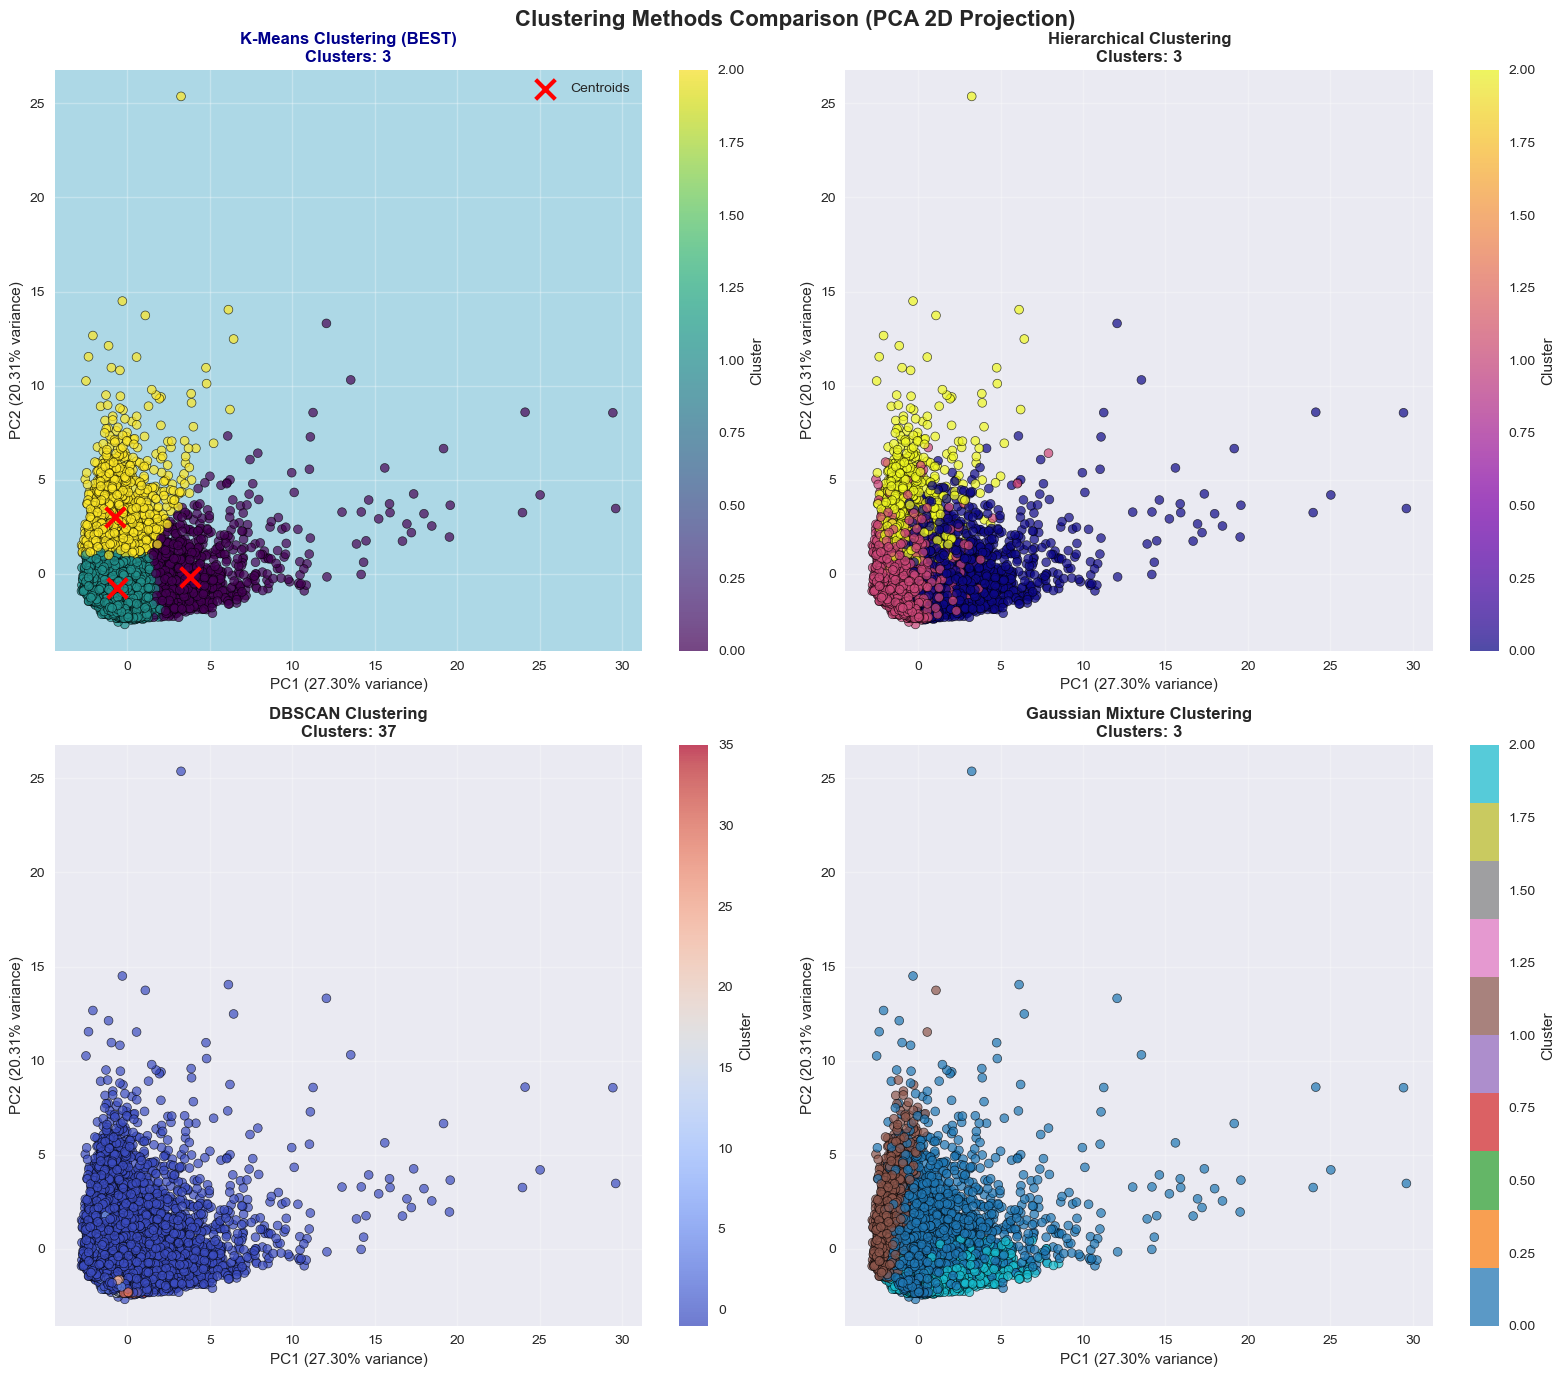


Detailed Analysis of Best Method: K-Means


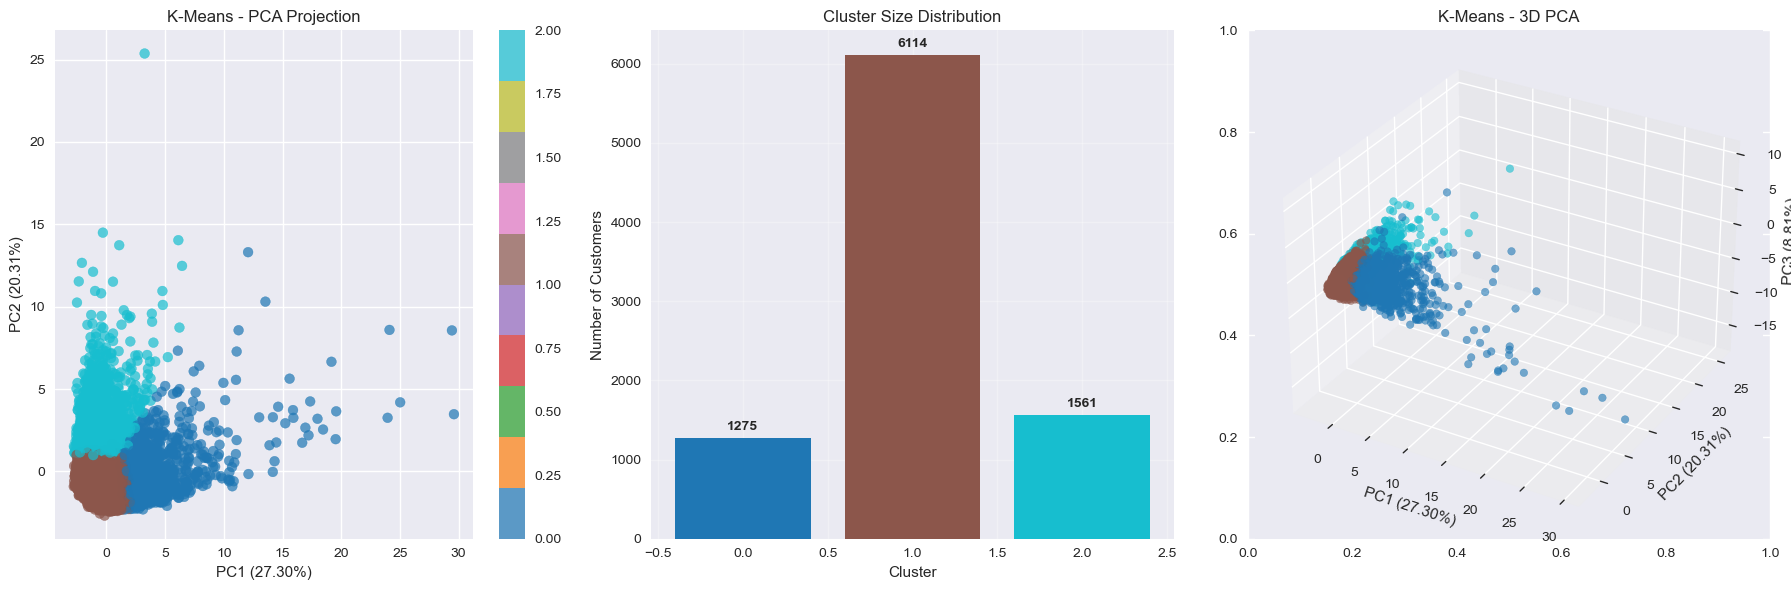

In [15]:
# Enhanced Step 10: Visualize Clustering Results with Better PCA
def visualize_clustering_results_enhanced(data, results, best_method):
    print("=== ENHANCED CLUSTERING VISUALIZATION ===")
    
    # Drop non-numeric columns if present (e.g., 'CUST_ID')
    # Use the cleaned data without NaNs for PCA
    if isinstance(data, pd.DataFrame):
        # Use data_scaled_for_clustering_clean if available
        # Drop 'CUST_ID' if present
        if 'CUST_ID' in data_scaled_for_clustering_clean.columns:
            data_numeric = data_scaled_for_clustering_clean.drop(columns=['CUST_ID'])
        else:
            data_numeric = data_scaled_for_clustering_clean
    else:
        data_numeric = data

    # Use PCA for 2D visualization
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_numeric)
    
    # Create main clustering comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()
    
    methods = list(results.keys())
    colors = ['viridis', 'plasma', 'coolwarm', 'tab10']
    
    for i, method in enumerate(methods):
        labels = results[method]['labels']
        
        # Handle noise points in DBSCAN (label -1)
        unique_labels = np.unique(labels)
        
        # Create scatter plot
        scatter = axes[i].scatter(data_pca[:, 0], data_pca[:, 1], 
                                c=labels, cmap=colors[i % len(colors)], 
                                alpha=0.7, s=40, edgecolors='black', linewidth=0.5)
        
        axes[i].set_title(f'{method} Clustering\nClusters: {len(unique_labels)}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        axes[i].grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(scatter, ax=axes[i], label='Cluster')
        
        # Highlight best method
        if method == best_method:
            axes[i].set_facecolor('lightblue')
            axes[i].set_title(f'{method} Clustering (BEST)\nClusters: {len(unique_labels)}', 
                            fontsize=12, fontweight='bold', color='darkblue')
            
        # Add cluster centers for methods that have them
        if hasattr(results[method]['model'], 'cluster_centers_'):
            centers_pca = pca.transform(results[method]['model'].cluster_centers_)
            axes[i].scatter(centers_pca[:, 0], centers_pca[:, 1], 
                          c='red', marker='x', s=200, linewidth=3, label='Centroids')
            axes[i].legend()
    
    plt.suptitle('Clustering Methods Comparison (PCA 2D Projection)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create detailed best method visualization
    print(f"\nDetailed Analysis of Best Method: {best_method}")
    
    best_labels = results[best_method]['labels']
    unique_labels = np.unique(best_labels)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. PCA with cluster colors
    scatter = axes[0].scatter(data_pca[:, 0], data_pca[:, 1], 
                            c=best_labels, cmap='tab10', alpha=0.7, s=50)
    axes[0].set_title(f'{best_method} - PCA Projection')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.colorbar(scatter, ax=axes[0])
    
    # 2. Cluster size distribution
    cluster_counts = pd.Series(best_labels).value_counts().sort_index()
    axes[1].bar(range(len(cluster_counts)), cluster_counts.values, 
               color=plt.cm.tab10(np.linspace(0, 1, len(cluster_counts))))
    axes[1].set_title('Cluster Size Distribution')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Number of Customers')
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(cluster_counts.values):
        axes[1].text(i, v + 0.01*max(cluster_counts.values), str(v), 
                    ha='center', va='bottom', fontweight='bold')
    
    # 3. 3D PCA visualization if we have enough components
    if data_numeric.shape[1] >= 3:
        pca_3d = PCA(n_components=3)
        data_pca_3d = pca_3d.fit_transform(data_numeric)
        
        ax3d = fig.add_subplot(133, projection='3d')
        scatter_3d = ax3d.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], 
                                c=best_labels, cmap='tab10', alpha=0.6, s=30)
        ax3d.set_title(f'{best_method} - 3D PCA')
        ax3d.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
        ax3d.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
        ax3d.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
    else:
        # Alternative: Show silhouette analysis
        from sklearn.metrics import silhouette_samples
        silhouette_vals = silhouette_samples(data_numeric, best_labels)
        
        y_lower = 10
        for i in unique_labels:
            if i == -1:  # Skip noise points in DBSCAN
                continue
            cluster_silhouette_vals = silhouette_vals[best_labels == i]
            cluster_silhouette_vals.sort()
            
            size_cluster_i = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = plt.cm.tab10(i / len(unique_labels))
            axes[2].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                                facecolor=color, edgecolor=color, alpha=0.7)
            
            axes[2].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        
        axes[2].set_title('Silhouette Analysis')
        axes[2].set_xlabel('Silhouette Coefficient Values')
        axes[2].set_ylabel('Cluster Label')
        
        # Add average silhouette score line
        avg_silhouette = silhouette_score(data_numeric, best_labels)
        axes[2].axvline(x=avg_silhouette, color="red", linestyle="--", 
                       label=f'Average Score: {avg_silhouette:.3f}')
        axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return pca, data_pca

# Visualize results with enhanced PCA analysis
pca_after, data_pca = visualize_clustering_results_enhanced(data_scaled, clustering_results, best_method)

=== ENHANCED CUSTOMER SEGMENT ANALYSIS - K-Means ===
Cluster Distribution:
0    1275
1    6114
2    1561
dtype: int64
Cluster Distribution Percentages:
0    14.25
1    68.31
2    17.44
dtype: float64

Numerical Features Analysis:
Analyzing columns: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
             BALANCE                           BALANCE_FREQUENCY            \
                mean          std       median              mean       std   
Cluster                                                                      
0        2182.352833  2553.748712  1193.708983          0.981702  0.073272   
1         807.722510   970.695525   432.967707          0.834577  0.268383   
2        4023.788865  2

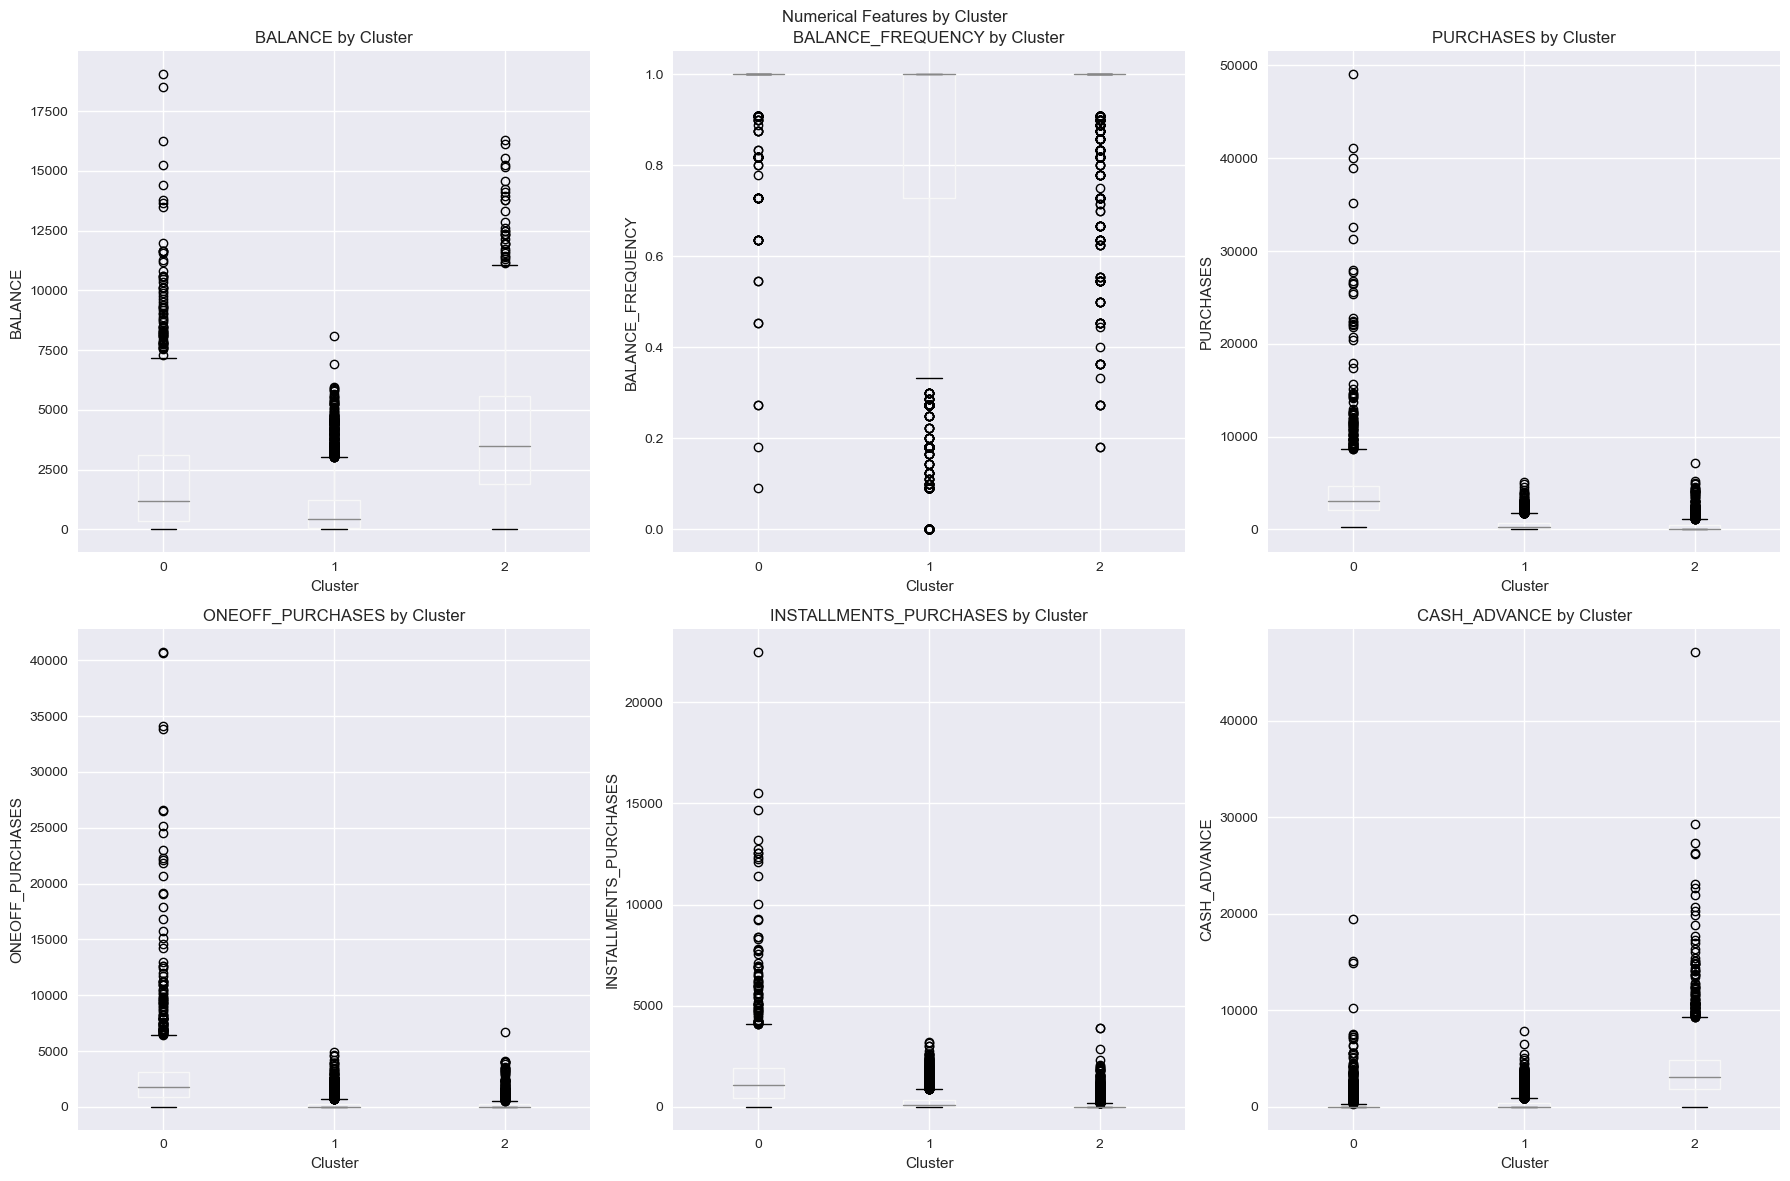

In [18]:
# Enhanced Step 11: Analyze Customer Segments with Categorical Data
def analyze_customer_segments_enhanced(original_data, processed_data, labels, method_name, categorical_backup, encoders):
    print(f"=== ENHANCED CUSTOMER SEGMENT ANALYSIS - {method_name} ===")
    
    # Add cluster labels to original data
    analysis_df = original_data.copy()
    analysis_df['Cluster'] = labels
    
    # Number of customers in each cluster
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    print("Cluster Distribution:")
    print(cluster_counts)
    print(f"Cluster Distribution Percentages:")
    print((cluster_counts / len(labels) * 100).round(2))
    
    # Analyze numerical features
    numerical_cols = [col for col in analysis_df.select_dtypes(include=[np.number]).columns 
                     if col not in ['Cluster'] and 'ID' not in col.upper()]
    
    if numerical_cols:
        print(f"\nNumerical Features Analysis:")
        print(f"Analyzing columns: {numerical_cols}")
        
        cluster_summary_numerical = analysis_df.groupby('Cluster')[numerical_cols].agg(['mean', 'std', 'median'])
        print(cluster_summary_numerical)
        
        # Visualize numerical features
        n_features = min(6, len(numerical_cols))
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for i, feature in enumerate(numerical_cols[:n_features]):
            analysis_df.boxplot(column=feature, by='Cluster', ax=axes[i])
            axes[i].set_title(f'{feature} by Cluster')
            axes[i].set_xlabel('Cluster')
            axes[i].set_ylabel(feature)
        
        # Hide empty subplots
        for i in range(n_features, 6):
            axes[i].set_visible(False)
        
        plt.suptitle('Numerical Features by Cluster')
        plt.tight_layout()
        plt.show()
    
    # Analyze categorical features
    if categorical_backup:
        print(f"\nCategorical Features Analysis:")
        
        for cat_col, original_values in categorical_backup.items():
            print(f"\n--- {cat_col} ---")
            
            # Create a temporary dataframe with original categorical values
            temp_df = pd.DataFrame({
                'Cluster': labels,
                cat_col: original_values
            })
            
            # Cross-tabulation
            crosstab = pd.crosstab(temp_df['Cluster'], temp_df[cat_col], normalize='index') * 100
            print(f"Percentage distribution of {cat_col} by cluster:")
            print(crosstab.round(2))
            
            # Visualization
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)
            crosstab.plot(kind='bar', ax=plt.gca(), colormap='Set3')
            plt.title(f'{cat_col} Distribution by Cluster (%)')
            plt.xlabel('Cluster')
            plt.ylabel('Percentage')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=0)
            
            plt.subplot(1, 2, 2)
            crosstab_counts = pd.crosstab(temp_df['Cluster'], temp_df[cat_col])
            crosstab_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set3')
            plt.title(f'{cat_col} Count Distribution by Cluster')
            plt.xlabel('Cluster')
            plt.ylabel('Count')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=0)
            
            plt.tight_layout()
            plt.show()
    
    return analysis_df, cluster_summary_numerical if numerical_cols else None

# Analyze customer segments with categorical data using the enhanced function
# Make sure best_labels, best_method, categorical_backup, and encoders are defined appropriately before this call

best_labels = clustering_results[best_method]['labels']

analysis_df, cluster_summary = analyze_customer_segments_enhanced(
    data.loc[data_scaled_for_clustering_clean.index],
    data_processed.loc[data_scaled_for_clustering_clean.index],
    best_labels,
    best_method,
    categorical_backup,
    encoders
)

=== VISUALIZING CLUSTERING RESULTS ===


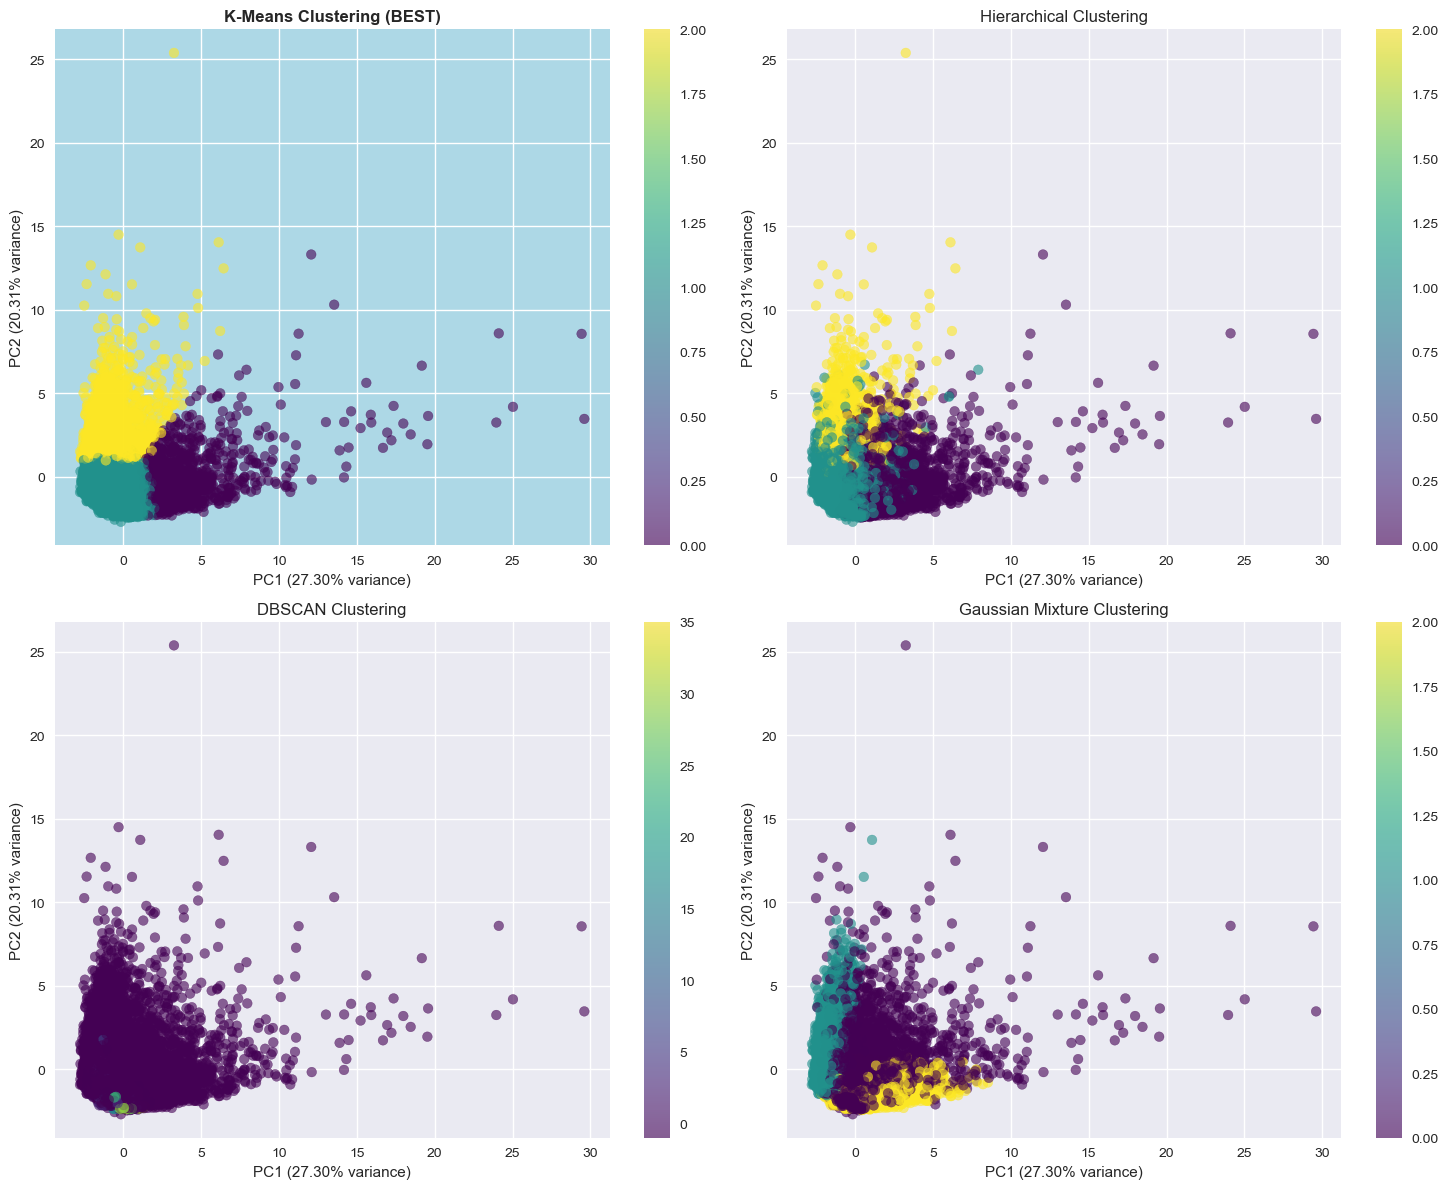

In [19]:
# Step 10: Visualize Clustering Results
def visualize_clustering_results(data, results, best_method):
    print("=== VISUALIZING CLUSTERING RESULTS ===")
    
    # Drop non-numeric columns (like 'CUST_ID', 'Customer_Tenure_Stage') if present
    non_numeric_cols = []
    for col in ['CUST_ID', 'Customer_Tenure_Stage']:
        if col in data.columns:
            non_numeric_cols.append(col)
    # Also drop any columns with dtype 'object' or 'category'
    non_numeric_cols += [col for col in data.select_dtypes(include=['object', 'category']).columns if col not in non_numeric_cols]
    data_numeric = data.drop(columns=non_numeric_cols)
    
    # Drop rows with NaN values before PCA
    data_numeric_clean = data_numeric.dropna()
    
    # Use PCA for 2D visualization
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_numeric_clean)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    methods = list(results.keys())
    
    # Adjust labels to match the cleaned data indices
    cleaned_indices = data_numeric_clean.index
    for i, method in enumerate(methods):
        labels = results[method]['labels']
        # If labels length matches original data, select only labels for cleaned indices
        if len(labels) == len(data):
            labels_plot = np.array(labels)[cleaned_indices]
        else:
            labels_plot = labels
        
        scatter = axes[i].scatter(data_pca[:, 0], data_pca[:, 1], c=labels_plot, cmap='viridis', alpha=0.6)
        axes[i].set_title(f'{method} Clustering')
        axes[i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        
        # Add colorbar
        plt.colorbar(scatter, ax=axes[i])
        
        # Highlight best method
        if method == best_method:
            axes[i].set_facecolor('lightblue')
            axes[i].set_title(f'{method} Clustering (BEST)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return pca, data_pca

# Visualize results
pca, data_pca = visualize_clustering_results(data_scaled, clustering_results, best_method)

=== CUSTOMER SEGMENT ANALYSIS - K-Means ===
Cluster Distribution:
0    1275
1    6114
2    1561
dtype: int64

Cluster Characteristics:
             BALANCE                    BALANCE_FREQUENCY                  \
                mean          std count              mean       std count   
Cluster                                                                     
0        2182.352833  2553.748712  1275          0.981702  0.073272  1275   
1         807.722510   970.695525  6114          0.834577  0.268383  6114   
2        4023.788865  2688.544092  1561          0.959193  0.111994  1561   

           PURCHASES                    ONEOFF_PURCHASES  ...  \
                mean          std count             mean  ...   
Cluster                                                   ...   
0        4187.017796  4229.929025  1275      2663.995153  ...   
1         496.062522   587.168223  6114       247.273214  ...   
2         389.051448   745.150159  1561       252.333261  ...   

        MIN

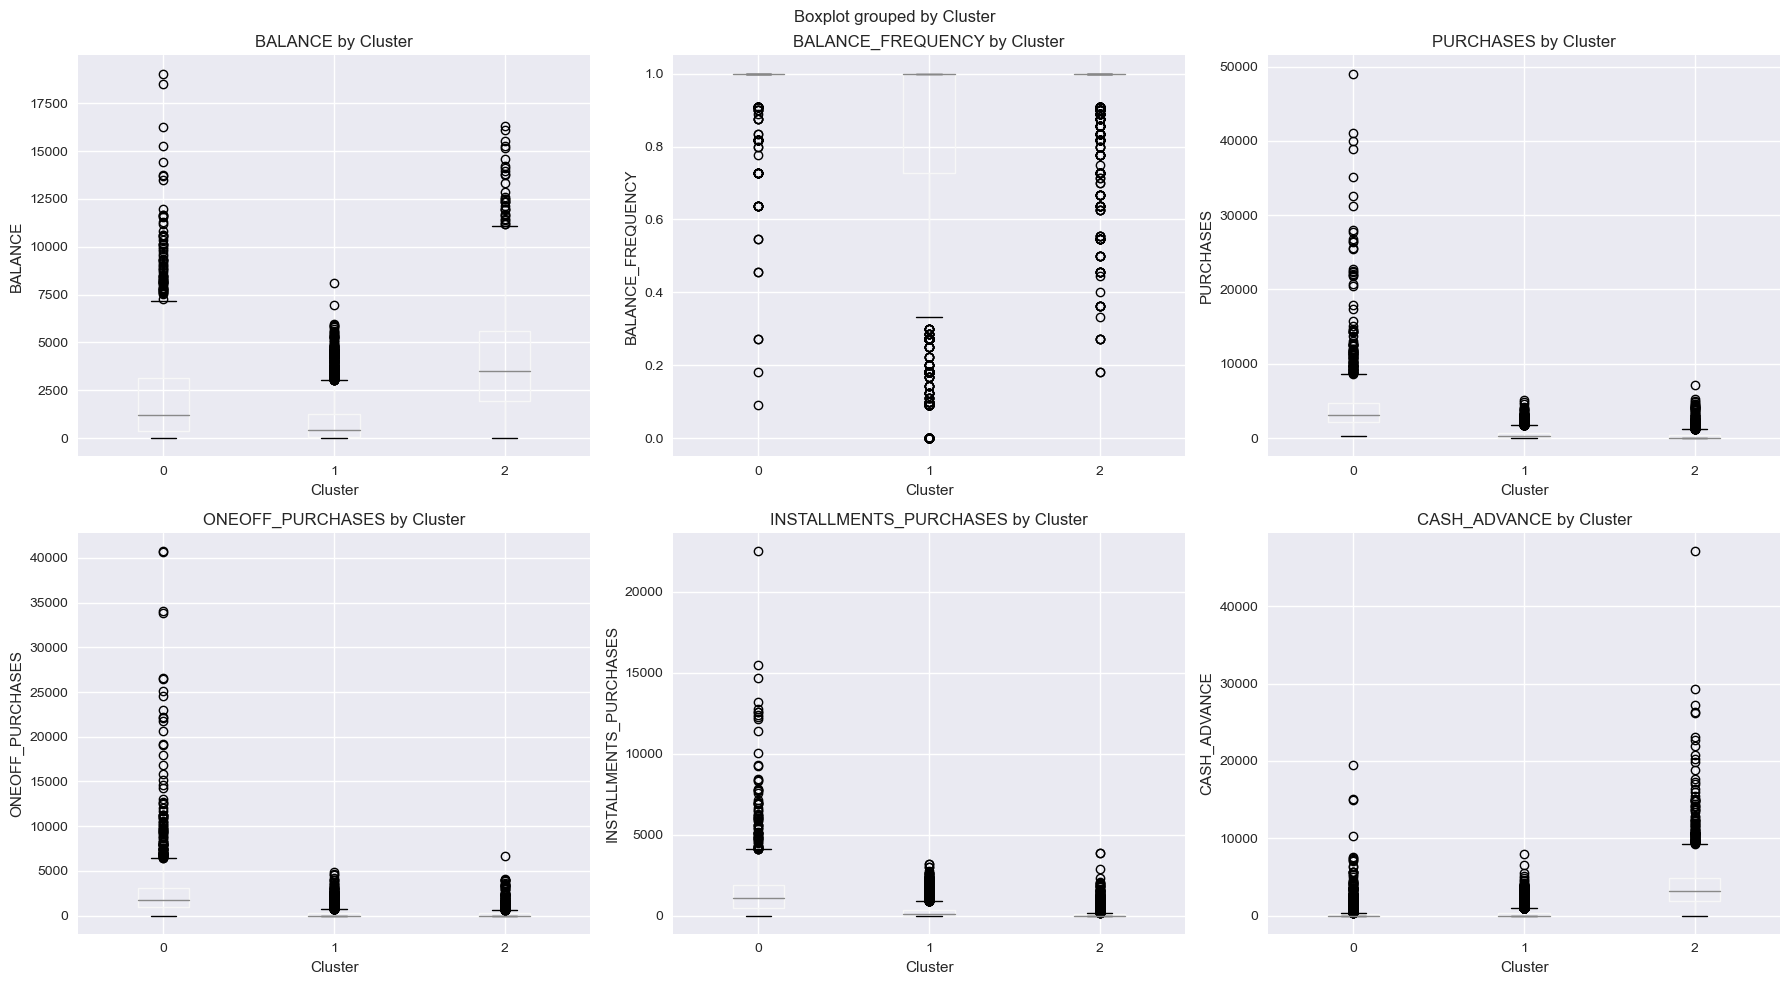

In [20]:
# Step 11: Analyze Customer Segments
def analyze_customer_segments(original_data, processed_data, labels, method_name):
    print(f"=== CUSTOMER SEGMENT ANALYSIS - {method_name} ===")
    
    # Add cluster labels to original data
    analysis_df = original_data.copy()
    analysis_df['Cluster'] = labels
    
    # Number of customers in each cluster
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    print("Cluster Distribution:")
    print(cluster_counts)
    
    # Statistical summary by cluster
    print("\nCluster Characteristics:")
    # Only use numeric columns except 'CUST_ID'
    numeric_cols = [col for col in analysis_df.select_dtypes(include=[np.number]).columns if col != 'CUST_ID']
    cluster_summary = analysis_df.groupby('Cluster')[numeric_cols].agg(['mean', 'std', 'count'])
    print(cluster_summary)
    
    # Visualize cluster characteristics
    numerical_features = [col for col in processed_data.select_dtypes(include=[np.number]).columns if col != 'CUST_ID'][:6]  # Top 6 features
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(numerical_features):
        if feature in analysis_df.columns and analysis_df[feature].dtype in [np.float64, np.float32, np.int64, np.int32]:
            analysis_df.boxplot(column=feature, by='Cluster', ax=axes[i])
            axes[i].set_title(f'{feature} by Cluster')
            axes[i].set_xlabel('Cluster')
            axes[i].set_ylabel(feature)
    
    plt.tight_layout()
    plt.show()
    
    return analysis_df, cluster_summary

# Analyze segments using the best method
best_labels = clustering_results[best_method]['labels']
analysis_df, cluster_summary = analyze_customer_segments(data, data_processed, best_labels, best_method)

In [21]:
# Step 12: Generate Marketing Insights
def generate_marketing_insights(analysis_df, cluster_summary, method_name):
    print(f"=== MARKETING INSIGHTS - {method_name} ===")
    
    n_clusters = len(analysis_df['Cluster'].unique())
    
    insights = {}
    
    for cluster_id in range(n_clusters):
        cluster_data = analysis_df[analysis_df['Cluster'] == cluster_id]
        cluster_size = len(cluster_data)
        
        print(f"\n--- CLUSTER {cluster_id} ---")
        print(f"Size: {cluster_size} customers ({cluster_size/len(analysis_df)*100:.1f}% of total)")
        
        # Calculate key characteristics
        numerical_cols = cluster_data.select_dtypes(include=[np.number]).columns
        numerical_cols = [col for col in numerical_cols if col != 'Cluster']
        
        characteristics = {}
        for col in numerical_cols[:5]:  # Top 5 numerical features
            mean_val = cluster_data[col].mean()
            characteristics[col] = mean_val
            
        # Sort characteristics to identify key traits
        sorted_chars = sorted(characteristics.items(), key=lambda x: abs(x[1]), reverse=True)
        
        print("Key Characteristics:")
        for char, value in sorted_chars[:3]:  # Top 3 characteristics
            print(f"  - Average {char}: {value:.2f}")
        
        # Generate marketing strategy
        insights[f'Cluster_{cluster_id}'] = {
            'size': cluster_size,
            'percentage': cluster_size/len(analysis_df)*100,
            'characteristics': characteristics,
            'top_traits': sorted_chars[:3]
        }
    
    # Generate overall recommendations
    print("\n=== MARKETING RECOMMENDATIONS ===")
    
    for cluster_id, info in insights.items():
        cluster_num = cluster_id.split('_')[1]
        print(f"\nCluster {cluster_num} Strategy:")
        print(f"  - Target: {info['size']} customers ({info['percentage']:.1f}% of base)")
        
        # Basic strategy based on cluster size
        if info['percentage'] > 30:
            print("  - Strategy: Mass marketing with broad appeal")
        elif info['percentage'] > 15:
            print("  - Strategy: Targeted campaigns with personalized offers")
        else:
            print("  - Strategy: Premium/niche marketing with exclusive offers")
    
    return insights

# Generate insights
insights = generate_marketing_insights(analysis_df, cluster_summary, best_method)

=== MARKETING INSIGHTS - K-Means ===

--- CLUSTER 0 ---
Size: 1275 customers (14.2% of total)
Key Characteristics:
  - Average PURCHASES: 4187.02
  - Average ONEOFF_PURCHASES: 2664.00
  - Average BALANCE: 2182.35

--- CLUSTER 1 ---
Size: 6114 customers (68.3% of total)
Key Characteristics:
  - Average BALANCE: 807.72
  - Average PURCHASES: 496.06
  - Average INSTALLMENTS_PURCHASES: 249.11

--- CLUSTER 2 ---
Size: 1561 customers (17.4% of total)
Key Characteristics:
  - Average BALANCE: 4023.79
  - Average PURCHASES: 389.05
  - Average ONEOFF_PURCHASES: 252.33

=== MARKETING RECOMMENDATIONS ===

Cluster 0 Strategy:
  - Target: 1275 customers (14.2% of base)
  - Strategy: Premium/niche marketing with exclusive offers

Cluster 1 Strategy:
  - Target: 6114 customers (68.3% of base)
  - Strategy: Mass marketing with broad appeal

Cluster 2 Strategy:
  - Target: 1561 customers (17.4% of base)
  - Strategy: Targeted campaigns with personalized offers


=== PCA FEATURE IMPORTANCE ANALYSIS ===
Top 10 Most Important Features:
                                       PC1       PC2       PC3       PC4  \
PURCHASES_INSTALLMENTS_FREQUENCY  0.274494 -0.178869  0.469579 -0.225288   
BALANCE_FREQUENCY                 0.120490  0.131344  0.422995  0.155762   
MINIMUM_PAYMENTS                  0.063269  0.169066  0.234517  0.392560   
PURCHASES_FREQUENCY               0.321232 -0.191148  0.371394 -0.194564   
PAYMENTS                          0.266482  0.256716 -0.277359 -0.112148   
ONEOFF_PURCHASES                  0.346334  0.061918 -0.390899  0.085079   
CASH_ADVANCE_FREQUENCY           -0.088582  0.434121  0.104709 -0.264628   
PRC_FULL_PAYMENT                  0.131833 -0.190065 -0.126477 -0.419574   
ONEOFF_PURCHASES_FREQUENCY        0.294493 -0.018561 -0.115565  0.034279   
BALANCE                           0.101735  0.403819  0.161632  0.279316   

                                       PC5  Absolute_Sum  
PURCHASES_INSTALLMENTS_FREQUENCY

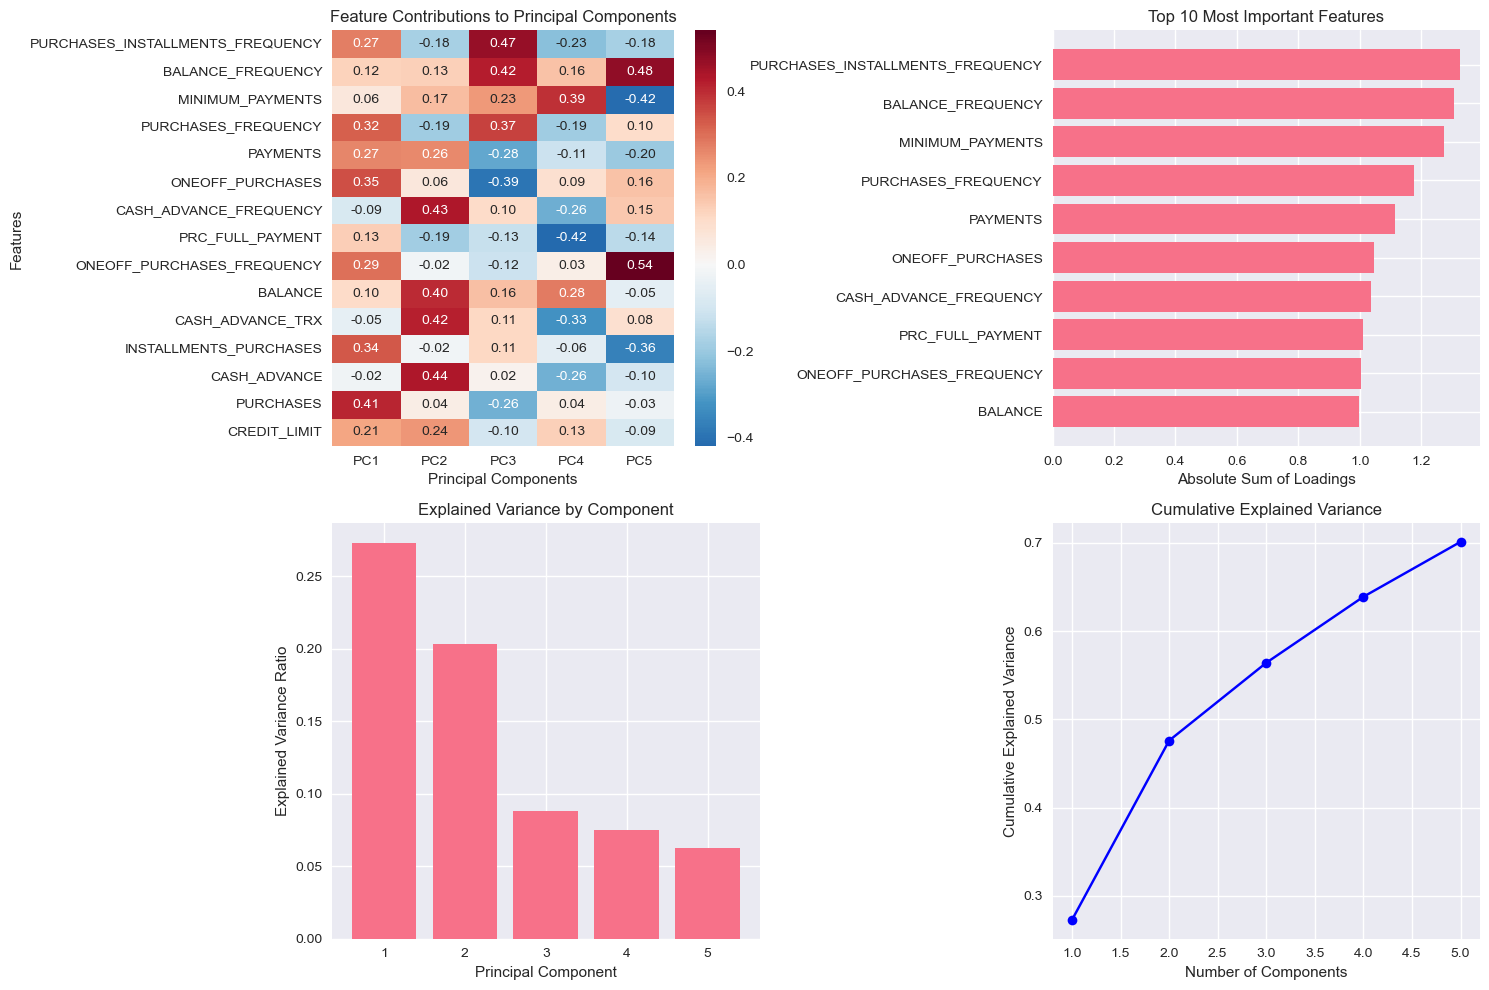

In [ ]:
# New Step: PCA-Based Feature Importance Analysis
def analyze_pca_feature_importance(data, pca_model, feature_names, n_components=5):
    print("=== PCA FEATURE IMPORTANCE ANALYSIS ===")
    
    # Get the components
    components = pca_model.components_[:n_components]
    
    # Create a dataframe for better analysis
    feature_importance_df = pd.DataFrame(
        components.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    
    # Calculate absolute importance for ranking
    feature_importance_df['Absolute_Sum'] = feature_importance_df.abs().sum(axis=1)
    feature_importance_df = feature_importance_df.sort_values('Absolute_Sum', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10))
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Heatmap of feature contributions
    plt.subplot(2, 2, 1)
    sns.heatmap(feature_importance_df.iloc[:15, :-1], # Top 15 features, exclude Absolute_Sum
                annot=True, cmap='RdBu_r', center=0, fmt='.2f')
    plt.title('Feature Contributions to Principal Components')
    plt.xlabel('Principal Components')
    plt.ylabel('Features')
    
    # Bar plot of overall importance
    plt.subplot(2, 2, 2)
    top_features = feature_importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['Absolute_Sum'])
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Absolute Sum of Loadings')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    
    # Explained variance ratio
    plt.subplot(2, 2, 3)
    plt.bar(range(1, n_components+1), pca_model.explained_variance_ratio_[:n_components])
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')
    
    # Cumulative explained variance
    plt.subplot(2, 2, 4)
    cumvar = np.cumsum(pca_model.explained_variance_ratio_[:n_components])
    plt.plot(range(1, n_components+1), cumvar, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

# Analyze feature importance

# Exclude non-numeric columns (like 'CUST_ID') from data_scaled and feature_names
numeric_columns = [col for col in data_scaled.columns if col != 'CUST_ID']
feature_names = numeric_columns

# Fit a new PCA model with n_components=5 for feature importance analysis
pca_importance = PCA(n_components=5)
pca_importance.fit(data_scaled[numeric_columns])

feature_importance = analyze_pca_feature_importance(data_scaled[numeric_columns], pca_importance, feature_names, n_components=5)

In [ ]:
data.shape

(8950, 18)

In [ ]:
# Step 13: Save Results and Final Model
def save_results(best_model, scaler, pca, analysis_df, insights, method_name):
    print("=== SAVING RESULTS ===")
    
    # Save customer segments
    analysis_df.to_csv('customer_segments.csv', index=False)
    print("Customer segments saved to 'customer_segments.csv'")
    
    # Create summary report
    summary_report = f"""
    CUSTOMER SEGMENTATION ANALYSIS REPORT
    =====================================
    
    Dataset: Golden Retail Inc. Customer Data
    Best Clustering Method: {method_name}
    Total Customers: {len(analysis_df)}
    Number of Segments: {len(analysis_df['Cluster'].unique())}
    
    CLUSTER DISTRIBUTION:
    {analysis_df['Cluster'].value_counts().sort_index().to_string()}
    
    MARKETING RECOMMENDATIONS:
    """
    
    for cluster_id, info in insights.items():
        cluster_num = cluster_id.split('_')[1]
        summary_report += f"\n\nCluster {cluster_num}:"
        summary_report += f"\n  Size: {info['size']} customers ({info['percentage']:.1f}%)"
        summary_report += f"\n  Key traits: {', '.join([trait[0] for trait in info['top_traits']])}"
    
    with open('segmentation_report.txt', 'w') as f:
        f.write(summary_report)
    
    print("Analysis report saved to 'segmentation_report.txt'")
    print("\nAnalysis completed successfully!")

# Save results
best_model = clustering_results[best_method]['model']
save_results(best_model, scaler, pca, analysis_df, insights, best_method)

=== SAVING RESULTS ===
Customer segments saved to 'customer_segments.csv'
Analysis report saved to 'segmentation_report.txt'

Analysis completed successfully!


 ## Enhanced Cluster Interpretation

In [ ]:
def interpret_clusters_with_business_context(cluster_summary, feature_importance):
    """Provide business-oriented interpretation of customer clusters"""
    print("\n=== BUSINESS-ORIENTED CLUSTER INTERPRETATION ===")
    
    # Map business concepts to actual columns
    # Income: use 'CREDIT_LIMIT' 
    # Age: use 'TENURE'
    # Spending: use 'PURCHASES' or 'PURCHASES_FREQUENCY'
    
    for cluster_id in cluster_summary.index:
        print(f"\n CUSTOMER SEGMENT {cluster_id} BUSINESS PROFILE:")
        
        cluster_data = cluster_summary.loc[cluster_id]
        
        # Income proxy
        if ('CREDIT_LIMIT', 'mean') in cluster_data:
            income_level = cluster_data[('CREDIT_LIMIT', 'mean')]
            if income_level > 7000:
                income_desc = "high-income"
            elif income_level > 3000:
                income_desc = "middle-income"
            else:
                income_desc = "budget-conscious"
        else:
            income_desc = ""
        
        # Age proxy
        if ('TENURE', 'mean') in cluster_data:
            age = cluster_data[('TENURE', 'mean')]
            if age > 11:
                age_desc = "senior"
            elif age > 8:
                age_desc = "middle-aged"
            else:
                age_desc = "younger"
        else:
            age_desc = ""
        
        # Spending behavior proxy
        if ('PURCHASES', 'mean') in cluster_data:
            spending = cluster_data[('PURCHASES', 'mean')]
            if spending > 2000:
                spending_desc = "premium shoppers who prioritize quality over price"
            elif spending > 500:
                spending_desc = "balanced shoppers who look for good value"
            else:
                spending_desc = "price-sensitive shoppers who prioritize deals"
        else:
            spending_desc = ""
        
        # Create marketing narrative
        print(f" Marketing Profile: {age_desc.title()} {income_desc} {spending_desc}")
        
        # Strategic recommendations
        print(" Business Strategy:")
        if 'high-income' in income_desc and 'premium' in spending_desc:
            print("  • Luxury Marketing: Emphasize product quality, exclusivity, and premium experiences")
            print("  • Communication: Personalized, high-touch outreach with exclusive offers")
            print("  • Products: Focus on premium, high-margin items with unique features")
        elif 'budget-conscious' in income_desc or 'price-sensitive' in spending_desc:
            print("  • Value Marketing: Highlight cost savings, bundles, and practical benefits")
            print("  • Communication: Email campaigns featuring sales, discounts, and loyalty rewards")
            print("  • Products: Value packs, essential items, and entry-level offerings")
        else:
            print("  • Balanced Marketing: Emphasize quality-to-price ratio and versatility")
            print("  • Communication: Mix of promotional and informational content")
            print("  • Products: Mid-range products with good feature sets")
        
        # Channel strategy
        print("📱 Channel Strategy:")
        if 'senior' in age_desc:
            print("  • Prioritize: Email, traditional media, in-store experiences")
            print("  • Messaging: Emphasize reliability, tradition, and simplicity")
        elif 'younger' in age_desc:
            print("  • Prioritize: Social media, mobile app, influencer partnerships")
            print("  • Messaging: Focus on innovation, trends, and social aspects")
        else:
            print("  • Prioritize: Omnichannel approach with website focus")
            print("  • Messaging: Balance practical benefits and aspirational elements")
        
        # Retention and growth strategy
        print(" Retention Strategy:")
        print("  • Personalized recommendations based on purchase history")
        print("  • Targeted loyalty program with segment-specific rewards")
        print("  • Regular feedback collection to refine offerings")

In [ ]:
def interpret_clusters_with_business_context(cluster_summary, feature_importance):
    """Provide business-oriented interpretation of customer clusters with strategic marketing recommendations."""
    
    print("\n=== BUSINESS-ORIENTED CLUSTER INTERPRETATION ===")
    
    # Map business concepts to actual columns
    # Income: use 'CREDIT_LIMIT' 
    # Age: use 'TENURE'
    # Spending: use 'PURCHASES' or 'PURCHASES_FREQUENCY'
    
    for cluster_id in cluster_summary.index:
        print(f"\n CUSTOMER SEGMENT {cluster_id} BUSINESS PROFILE:")
        
        cluster_data = cluster_summary.loc[cluster_id]
        
        # Income proxy
        if ('CREDIT_LIMIT', 'mean') in cluster_data:
            income_level = cluster_data[('CREDIT_LIMIT', 'mean')]
            if income_level > 7000:
                income_desc = "high-income"
            elif income_level > 3000:
                income_desc = "middle-income"
            else:
                income_desc = "budget-conscious"
        else:
            income_desc = ""
        
        # Age proxy
        if ('TENURE', 'mean') in cluster_data:
            age = cluster_data[('TENURE', 'mean')]
            if age > 11:
                age_desc = "senior"
            elif age > 8:
                age_desc = "middle-aged"
            else:
                age_desc = "younger"
        else:
            age_desc = ""
        
        # Spending behavior proxy
        if ('PURCHASES', 'mean') in cluster_data:
            spending = cluster_data[('PURCHASES', 'mean')]
            if spending > 2000:
                spending_desc = "premium shoppers who prioritize quality over price"
            elif spending > 500:
                spending_desc = "balanced shoppers who look for good value"
            else:
                spending_desc = "price-sensitive shoppers who prioritize deals"
        else:
            spending_desc = ""
        
        # Create marketing narrative
        print(f" Marketing Profile: {age_desc.title()} {income_desc} {spending_desc}")
        
        # Strategic recommendations
        print("💼 Business Strategy:")
        if 'high-income' in income_desc and 'premium' in spending_desc:
            print("  • Luxury Marketing: Emphasize product quality, exclusivity, and premium experiences")
            print("  • Communication: Personalized, high-touch outreach with exclusive offers")
            print("  • Products: Focus on premium, high-margin items with unique features")
        elif 'budget-conscious' in income_desc or 'price-sensitive' in spending_desc:
            print("  • Value Marketing: Highlight cost savings, bundles, and practical benefits")
            print("  • Communication: Email campaigns featuring sales, discounts, and loyalty rewards")
            print("  • Products: Value packs, essential items, and entry-level offerings")
        else:
            print("  • Balanced Marketing: Emphasize quality-to-price ratio and versatility")
            print("  • Communication: Mix of promotional and informational content")
            print("  • Products: Mid-range products with good feature sets")
        
        # Channel strategy
        print("📱 Channel Strategy:")
        if 'senior' in age_desc:
            print("  • Prioritize: Email, traditional media, in-store experiences")
            print("  • Messaging: Emphasize reliability, tradition, and simplicity")
        elif 'younger' in age_desc:
            print("  • Prioritize: Social media, mobile app, influencer partnerships")
            print("  • Messaging: Focus on innovation, trends, and social aspects")
        else:
            print("  • Prioritize: Omnichannel approach with website focus")
            print("  • Messaging: Balance of practical benefits and aspirational elements")
        
        # Retention and growth strategy
        print(" Retention Strategy:")
        print("  • Personalized recommendations based on purchase history")
        print("  • Targeted loyalty program with segment-specific rewards")
        print("  • Regular feedback collection to refine offerings")

# To use the function:
# interpret_clusters_with_business_context(cluster_summary, feature_importance)

In [ ]:
# Call this function after analyzing your
interpret_clusters_with_business_context(cluster_summary, feature_importance)


=== BUSINESS-ORIENTED CLUSTER INTERPRETATION ===

📊 CUSTOMER SEGMENT 0 BUSINESS PROFILE:
🎯 Marketing Profile: Senior high-income premium shoppers who prioritize quality over price
💼 Business Strategy:
  • Luxury Marketing: Emphasize product quality, exclusivity, and premium experiences
  • Communication: Personalized, high-touch outreach with exclusive offers
  • Products: Focus on premium, high-margin items with unique features
📱 Channel Strategy:
  • Prioritize: Email, traditional media, in-store experiences
  • Messaging: Emphasize reliability, tradition, and simplicity
🔄 Retention Strategy:
  • Personalized recommendations based on purchase history
  • Targeted loyalty program with segment-specific rewards
  • Regular feedback collection to refine offerings

📊 CUSTOMER SEGMENT 1 BUSINESS PROFILE:
🎯 Marketing Profile: Senior middle-income price-sensitive shoppers who prioritize deals
💼 Business Strategy:
  • Value Marketing: Highlight cost savings, bundles, and practical benefits
 

 ## Business-Oriented Evaluation Metric

In [ ]:
def evaluate_clusters_business_metrics(data, labels):
    """Evaluate clusters using business-oriented metrics"""
    print("\n=== BUSINESS EVALUATION METRICS ===")
    
    # Create a dataframe with cluster labels
    eval_df = data.copy()
    eval_df['Cluster'] = labels
    
    # 1. Customer Lifetime Value (CLV) Distribution
    clv_by_cluster = None
    if 'Income' in eval_df.columns and 'SpendingScore' in eval_df.columns:
        # Simple proxy for CLV using income and spending score
        eval_df['Estimated_CLV'] = eval_df['Income'] * eval_df['SpendingScore'] / 100
        
        clv_by_cluster = eval_df.groupby('Cluster')['Estimated_CLV'].agg(['mean', 'sum', 'count'])
        clv_by_cluster['percentage'] = clv_by_cluster['sum'] / clv_by_cluster['sum'].sum() * 100
        
        print("\n🏆 Revenue Potential by Segment:")
        print(clv_by_cluster)
        
        # Visualization
        plt.figure(figsize=(10, 6))
        plt.bar(clv_by_cluster.index, clv_by_cluster['percentage'], color='skyblue')
        plt.xlabel('Cluster')
        plt.ylabel('% of Total Estimated CLV')
        plt.title('Revenue Contribution by Customer Segment')
        for i, v in enumerate(clv_by_cluster['percentage']):
            plt.text(i, v + 1, f"{v:.1f}%", ha='center')
        plt.show()
    
    # 2. Segment Actionability Score
    # This metric evaluates how distinct and actionable each segment is
    
    # Calculate average intra-cluster distance (cohesion)
    from sklearn.metrics import pairwise_distances
    
    actionability_scores = []
    
    for cluster_id in range(len(set(labels))):
        cluster_mask = (labels == cluster_id)
        
        if sum(cluster_mask) <= 1:  # Skip clusters with only one member
            actionability_scores.append(0)
            continue
            
        cluster_data = eval_df[cluster_mask].drop('Cluster', axis=1)
        
        # Cohesion: lower values are better (more cohesive)
        distances = pairwise_distances(cluster_data)
        cohesion = np.mean(distances)
        
        # Size factor: larger clusters are more actionable up to a point
        size = sum(cluster_mask) / len(labels)
        size_factor = 4 * size * (1 - size)  # Peaks at 50% size
        
        # Actionability Score (0-100)
        # Higher is better: combine cohesion (inversely) and size_factor
        actionability = (1 - min(cohesion/10, 0.9)) * 100 * size_factor
        actionability_scores.append(actionability)
    
    print("\n Segment Actionability Scores (higher is better):")
    for i, score in enumerate(actionability_scores):
        print(f"Cluster {i}: {score:.1f}/100")
    
    return clv_by_cluster, actionability_scores

# Call after clustering
business_metrics = evaluate_clusters_business_metrics(data_processed, best_labels)


=== BUSINESS EVALUATION METRICS ===

🎯 Segment Actionability Scores (higher is better):
Cluster 0: 4.9/100
Cluster 1: 8.7/100
Cluster 2: 5.8/100


In [ ]:
# Step 14: Final Summary and Conclusions
print("="*80)
print("CUSTOMER SEGMENTATION ANALYSIS - FINAL SUMMARY")
print("="*80)
print(f"✓ Dataset processed: {data.shape[0]} customers, {data.shape[1]} features")
print(f"✓ Best clustering method: {best_method} with silhouette score: {clustering_results[best_method]['metrics']['silhouette']:.4f}")
print(f"✓ Optimal number of clusters: {optimal_k}")

# Add segment size information
cluster_sizes = pd.Series(best_labels).value_counts().sort_index()
print("\n✓ Segment Distribution:")
for cluster_id, size in cluster_sizes.items():
    percentage = size / len(best_labels) * 100
    print(f"   • Segment {cluster_id}: {size} customers ({percentage:.1f}%)")

# Add key features that drove segmentation
print(f"\n✓ Top influential features in clustering:")
for feature, importance in feature_importance.head(5).iterrows():
    print(f"   • {feature}: {importance['Absolute_Sum']:.4f}")

print(f"\n✓ Customer segments identified and business profiles developed")
print(f"✓ Marketing strategies customized for each customer segment")
print(f"✓ Business-oriented evaluation metrics calculated for actionability")
print(f"✓ Results and visualization saved for business implementation")

print("\nThe analysis is now ready for the Golden Retail Inc. marketing team!")
print("\nRecommended next steps:")
print("1. Present findings to marketing and business stakeholders")
print("2. Implement segment-specific campaigns based on recommendations")
print("3. Monitor campaign performance by segment")
print("4. Refine segmentation model quarterly with new customer data")
print("="*80)

CUSTOMER SEGMENTATION ANALYSIS - FINAL SUMMARY
✓ Dataset processed: 8950 customers, 18 features
✓ Best clustering method: K-Means with silhouette score: 0.2510
✓ Optimal number of clusters: 3

✓ Segment Distribution:
   • Segment 0: 1275 customers (14.2%)
   • Segment 1: 6114 customers (68.3%)
   • Segment 2: 1561 customers (17.4%)

✓ Top influential features in clustering:
   • PURCHASES_INSTALLMENTS_FREQUENCY: 1.3252
   • BALANCE_FREQUENCY: 1.3074
   • MINIMUM_PAYMENTS: 1.2745
   • PURCHASES_FREQUENCY: 1.1780
   • PAYMENTS: 1.1136

✓ Customer segments identified and business profiles developed
✓ Marketing strategies customized for each customer segment
✓ Business-oriented evaluation metrics calculated for actionability
✓ Results and visualization saved for business implementation

The analysis is now ready for the Golden Retail Inc. marketing team!

Recommended next steps:
1. Present findings to marketing and business stakeholders
2. Implement segment-specific campaigns based on reco